# PA005: High Value Customer Identification

## Solution Planning ( IOT )

### Input

### Business Problem

1. Select the most valuable customers to form the **"INSIDERS"** loyalty program
2. Dataset with product sales during 1 year ( Nov 2015 to Dec 2017 )

### Output

1. Referring people to be part of the **"INSIDERS"** loyalty program.
2. Report with the answers to the following questions:
     - Who are the people eligible to participate in the Insiders program?
     - How many customers will be part of the group?
     - What are the main characteristics of these customers?
     - What is the percentage of revenue contribution from Insiders?
     - What is the revenue expectation of this group for the coming months?
     - What are the conditions for a person to be eligible for Insiders?
     - What are the conditions for a person to be removed from Insiders?
     - What is the guarantee that the Insiders program is better than the rest of the base?
     - What actions can the marketing team take to increase revenue?

### Tasks

1. **Who are the people eligible to participate in the Insiders program?**
    - What does it mean to be eligible? What is a "valuable" customer for the company?
        - Invoicing:
            - High Average Ticket
            - High LTV
            - Low Recency or High Frequency (time between purchases)
            - High Basket Size (average amount of products purchased)
            - Low probability of Churn
            - High LTV forecast
            - High propensity to buy

        - Cost:
            - Low number of returns

        - Experience:
            - High average ratings
            
            
2. **How ​​many customers will be part of the group?**
    - Number of customers
    - % in relation to the total number of clients
    
    
3. **What are the main characteristics of these customers?**
    - Write key customer attributes
        - Age
        - Country
        - Wage
        
    - Write key customer buying behaviors (business metrics)
        - See above
    
    
4. **What percentage of revenue contribution comes from Insiders?**
    - Calculate the company's total revenue during the year.
    - Calculate revenue (%) for the Insiders cluster only.
    
    
5. **What is the expected revenue for this group for the coming months?**
    - Calculation of the LTV of the Insiders group
    - Time Series (ARMA, ARIMA, HoltWinter, etc.)
    

6. **What are the conditions for a person to be eligible for Insiders?**
    - What is the evaluation period?
    - Customer "performance" is close to the average of the Insiders cluster.
    
    
7. **What are the conditions for a person to be removed from Insiders?**
    - Customer "performance" is no longer closer to the average of the Insiders cluster.
    
    
8. **What is the guarantee that the Insiders program is better than the rest of the base?**
    - Hypothesis Test
    - A/B test
    
    
9. **What actions can the marketing team take to increase revenue?**
    - Discounts
    - Choice preferences
    - Exclusive products

# 0.0. Imports

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import scipy.stats       as st
import pandas as pd
import matplotlib.cm as cm
import re

import umap.umap_ as umap

from pandas_profiling import ProfileReport
from plotly import express as px
from sklearn import model_selection as ms

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import decomposition as d
from sklearn import preprocessing as pp


from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from IPython.core.display import HTML
from matplotlib import pyplot as plt
from IPython.display import Image

pd.options.mode.chained_assignment = None


## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML ('<style>.container {width:100% !important;} </style>') )
    pd.options.display.max_columns=None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr',False)
    
    sns.set()
    
jupyter_settings()

def m1_error(model_name,y,yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def feature_importance(model,x_train_n,y_train_n):
    
    # Model Training
    model.fit(x_train_n,y_train_n)
    
    # Importance
    importances = model.feature_importances_

    # Std
    std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)

    # Indice
    indices = np.argsort(importances)[::-1]

    # Print Feature Ranking
    print('Feature Ranking')
    df = pd.DataFrame()

    for i, j in zip(x_train_n,model.feature_importances_):
        aux = pd.DataFrame({'feature': i,'importance':j}, index=[0])
        df = pd.concat([df,aux],axis=0)

    print(df.sort_values('importance',ascending=False))

    value = x_train_n.shape[1]

    plt.figure()
    plt.title('Feature Importances')
    plt.bar(range(value),importances[indices] ,color='r',yerr=std[indices],align='center')
    plt.xticks(range(value),indices)
    plt.xlim([-1,value])
    plt.show()

## 0.2. Load dataset

In [4]:
!ls 

high-value-customers-jbm.ipynb	notebook-final-deploy.ipynb
notebook-deploy.ipynb


In [5]:
path = '/home/jordan/Estudismo/PA005_jordan_malheiros/data/'
# load data
df_raw = pd.read_csv( path+'Ecommerce.csv',low_memory=False,encoding='iso8859-1')
df_raw = df_raw.drop(columns=['Unnamed: 8'],axis=1) 

#df_raw.to_csv('Ecommerce.csv')



# 1.0 Data Description

In [6]:
df1 = df_raw.copy()

## 1.1. Rename columuns

In [7]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [8]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


## 1.3. Data types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [11]:
# Compute the dataframes based if they have costumer_id
df_missing = df1[df1['customer_id'].isna()]
df_missing = df_missing.drop(columns=['customer_id'])

df_not_missing = df1[~df1['customer_id'].isna()]


In [12]:
df_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country
622,536414,22139,NaN,56,29-Nov-16,0.00,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,United Kingdom


In [13]:
df_not_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [14]:
df1['customer_id'].max()

18287.0

In [15]:
# # Check if invoice_no of the missing invoice df is inside the invoice_no of the not missing, and if it does get the customer_id for that specific invoice_no
# df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice),:].head()

missing_invoice = df_missing['invoice_no'].drop_duplicates().to_frame()
df_complete_missing = missing_invoice

# Complete the customers_id based on the max id of the original df
df_complete_missing['customer_id'] = range(19000, 19000+len(df_complete_missing))
df_complete_missing = pd.merge(df_missing,df_complete_missing,how='left',on='invoice_no')

df_complete_missing.head()


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536414,22139,NaN,56,29-Nov-16,0.00,United Kingdom,19000
1,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,United Kingdom,19001
2,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,United Kingdom,19001
3,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,United Kingdom,19001
4,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,United Kingdom,19001


In [16]:
df1 = pd.concat([df_not_missing,df_complete_missing])

In [17]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
customer_id        0
country            0
dtype: int64

## 1.6. Change dtypes

In [18]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


## 1.7. Descriptive Statistics

In [19]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numeric Attributes

In [20]:
# Central Tendency - Media, Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion std, min, max, range , skew , kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
# Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']


In [21]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


***1. Check negative quantity( may be devolution) | 2. Unit Price equals 0 ? (promotion maybe)***
    


### 1.7.2 Categorical Attributes

In [22]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [23]:
# len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x))),'invoice_no'].drop_duplicates())
# len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x))),'invoice_no'].drop_duplicates())
# cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool (re.search('^[a-zA-Z]+$',x))),'stock_code'].unique()

#### Invoice No -> Invoice with letters and numbers

In [24]:
# Invoice Number
df_letter_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool (re.search('[^0-9]+',x))),:]

print('Total Number of Invoices: {}'.format(df_letter_invoice.shape[0]))
print('Total Number of Negative Quantitys: {}'.format(len(df_letter_invoice[df_letter_invoice['quantity'] < 0 ])))


Total Number of Invoices: 9291
Total Number of Negative Quantitys: 9288


#### Stock Code

In [25]:
# Check Stock code only characters
df1.loc[df1['stock_code'].apply(lambda x: bool (re.search('^[a-zA-Z]+$',x))),'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK', 'S', 'AMAZONFEE', 'm',
       'DCGSSBOY', 'DCGSSGIRL', 'B'], dtype=object)

In [26]:
df_stock_code = df1.loc[df1['stock_code'].apply(lambda x: bool (re.search('^[a-zA-Z]+$',x))),:]

#### Description

In [27]:
# df1 = df1.drop(columns=['description'])

#### Country

In [28]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA', 'Hong Kong'], dtype=object)

In [29]:
df1['country'].value_counts(normalize=True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [30]:
x = df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id',ascending=False)

In [31]:
x.head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0 Variable Filtering

In [32]:
df2 = df1.copy()

In [33]:
df2.shape

(541909, 8)

In [34]:
# 541909 
# Unit Price >= 0.04
# Stock Code invalid
# remove customer 16446
# drop with European and Unspecified


In [35]:
# === Numerical Attributes ==== #
# df2.loc[df2['unit_price'] > 0.03,['customer_id','description','unit_price']].sort_values('unit_price',ascending=True).head(10)
df2 = df2.loc[df2['unit_price'] >= 0.04,: ]

# === Categorical Attributes ==== #
# Stock Code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK', 'S', 'AMAZONFEE', 'm','DCGSSBOY', 'DCGSSGIRL', 'B'])]

# Description
df2 = df2.drop(columns=['description'])

# All the BAD USERS were detected on the 4.0 Section in the Univariated Analysis
bad_users = [16446,12346,15823,17548, 16546,13364,13762,12558,18268,12454,14557,16878,12607,14792,13672,17900,18274]

# Bad User
df2 = df2[~df2['customer_id'].isin( bad_users )]

# Map
df2 = df2[~df2['country'].isin(['European Community','Unspecified'])]


In [36]:
# Quantity
df2_returns = df2.loc[df2['quantity'] < 0, :].copy()
df2_purchases = df2.loc[df2['quantity'] >= 0, :].copy()

In [37]:
# df2_returns[df2_returns['customer_id'] == ]

# 3.0. Feature Engineering 

In [38]:
df3 = df2.copy()

## 3.1. Feature Creation

In [39]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates( ignore_index=True )

### 3.1.1 Gross Revenue

In [40]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:,'quantity'] * df2_purchases.loc[:, 'unit_price']

# # Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

### 3.1.2 Recency - Day from last purchase

In [41]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:,['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

### 3.1.3 Quantity of purchased (invoice quantity)

In [42]:
df_qte_invoice = (df2_purchases.loc[:,['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'qtd_invoices'}))
df_ref = pd.merge(df_ref,df_qte_invoice,on='customer_id', how='left')

### 3.1.4 Total Quantity of (products) items purchased

In [43]:
df_qtd_items = (df2_purchases.loc[:,['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtd_items'}))
df_ref = pd.merge(df_ref,df_qtd_items,on='customer_id', how='left')

### 3.1.5 Total Quantity (variety) of products 

In [44]:
df_qtd_variety = (df2_purchases.loc[:,['customer_id','stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code':'qtd_items_variety'}))
df_ref = pd.merge(df_ref,df_qtd_variety,on='customer_id', how='left')

### 3.1.6 Average Ticket Value

In [45]:
# ## Avg ticket
# df_avg_ticket = df2_purchases.loc[:,['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
# df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left' )

### 3.1.7 Frequency Purchase

In [46]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no','invoice_date']].drop_duplicates()
                                                 .groupby('customer_id')
                                                 .agg(max_ =('invoice_date','max'),
                                                      min_ =('invoice_date','min'),
                                                      days =('invoice_date',lambda x: ( (x.max() - x.min()).days) + 1),
                                                      buy  =('invoice_no','count'))).reset_index()

df_aux['frequency'] = df_aux[['days','buy']].apply(lambda x: x['buy'] / x['days'] if x['days'] != 0 else 0,axis=1)

df_ref = pd.merge(df_ref,df_aux[['customer_id','frequency']],on='customer_id',how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
qtd_invoices         91
qtd_items            91
qtd_items_variety    91
frequency            91
dtype: int64

### 3.1.8 Number of Returns

In [47]:
df_returns = df2_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1 

df_ref = pd.merge(df_ref,df_returns,how='left',on='customer_id')

df_ref.loc[df_ref['qtde_returns'].isna(),'qtde_returns'] = 0
df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
qtd_invoices         91
qtd_items            91
qtd_items_variety    91
frequency            91
qtde_returns          0
dtype: int64

### 3.1.9 Avg Basket Size

In [48]:
# df_ref['avg_basket_size'] = df_ref.apply(lambda x: x['qtd_items'] / x['qtd_invoices'] ,axis=1)
# df_ref.isna().sum()

### 3.1.10 Average Recency Days

In [49]:
# df_aux = df2[['customer_id','invoice_date',]].drop_duplicates().sort_values( ['customer_id', 'invoice_date'] )
# df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
# df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date


# df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

# df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# # average recency 
# df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# # merge
# df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
# df_ref.isna().sum()

### 3.1.11 Percentage of Products Returned

In [50]:
df_ref['percentage_returned'] =  (df_ref['qtde_returns'] /  df_ref['qtd_items'] ) * 100
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
qtd_invoices           91
qtd_items              91
qtd_items_variety      91
frequency              91
qtde_returns            0
percentage_returned    91
dtype: int64

# 4.0 EDA (Exploration Data Analysis)

In [51]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id            0
gross_revenue          0
recency_days           0
qtd_invoices           0
qtd_items              0
qtd_items_variety      0
frequency              0
qtde_returns           0
percentage_returned    0
dtype: int64

## 4.1 Univariate Analysis

**Notes**
1. Cluster Coesos e Separados
2. Métricas 
   - Min, max, range ( Dispersao)
   - Média e Mediana
   - Desvio Padrão e Variância.
   - Coeficiente de Variação (dp / media)
   - Distribuição
   

In [54]:
profile = ProfileReport(df4)
profile.to_file('output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1.1 Gross Revenue - OK


In [101]:
df4[df4['gross_revenue'] == 279138.02]
#df4[df4['gross_revenue'] == 259657.3]
#df4[df4['gross_revenue'] == 194550.79]
#df4[df4['gross_revenue'] == 140450.72]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned
905,14646,279138.02,1.0,72.0,196844.0,2060.0,0.20339,288.0,0.146309


In [81]:
# df3[df3['customer_id'] == 14911].sort_values('quantity',ascending=True)

### 4.1.2 Recency_days - CHECK


In [82]:
df4[df4['recency_days'] == 372] 

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned
0,17850,5391.21,372.0,34.0,1733.0,297.0,17.0,40.0,2.308136
101,17732,303.97,372.0,1.0,93.0,18.0,1.0,0.0,0.000000
102,12855,38.10,372.0,1.0,30.0,3.0,1.0,0.0,0.000000
104,17855,208.97,372.0,1.0,197.0,17.0,1.0,0.0,0.000000
106,17925,244.08,372.0,1.0,72.0,1.0,1.0,0.0,0.000000
110,13108,350.06,372.0,1.0,298.0,10.0,1.0,0.0,0.000000
120,15070,106.20,372.0,1.0,36.0,1.0,1.0,0.0,0.000000
128,15923,127.08,372.0,1.0,122.0,21.0,1.0,0.0,0.000000
129,16752,207.50,372.0,1.0,54.0,9.0,1.0,0.0,0.000000
131,15363,326.00,372.0,1.0,144.0,16.0,1.0,1.0,0.694444


In [83]:
df3[df3['customer_id'] == 15823]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country


In [84]:
# BAD USER
df4[df4['customer_id'] == 15823]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned


### 4.1.3 qtd invoices - OK

In [85]:
df4[df4['qtd_invoices'] == 206] 

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned
46,12748,32317.32,0.0,206.0,25511.0,4580.0,0.550802,1535.0,6.017012


In [86]:
df4[df4['qtd_invoices'] == 199] 

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned
65,14911,140450.72,1.0,199.0,80263.0,5673.0,0.533512,3332.0,4.151352


In [87]:
df4[df4['qtd_invoices'] == 124] 

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned
67,17841,40967.72,1.0,124.0,23053.0,7838.0,0.33244,203.0,0.88058


In [88]:
df4[df4['qtd_invoices'] == 97]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned
253,13089,58825.83,2.0,97.0,31070.0,1818.0,0.263587,283.0,0.910846


### 4.1.4 qtd items - OK

In [89]:
df4[df4['qtd_items'] == 196844]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned
905,14646,279138.02,1.0,72.0,196844.0,2060.0,0.20339,288.0,0.146309


In [90]:
df3[df3['customer_id'] == 14646].sort_values('quantity',ascending=True).head(5)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
319805,C564899,22956,-144,2017-08-29,1.85,14646,Netherlands
319806,C564899,21787,-144,2017-08-29,0.65,14646,Netherlands
271584,560710,22567,1,2017-07-18,1.45,14646,Netherlands
295508,562789,23359,1,2017-08-07,1.95,14646,Netherlands
295507,562789,23360,1,2017-08-07,1.95,14646,Netherlands


### 4.1.5 qtd_items_variety - OK

In [91]:
df4[df4['qtd_items_variety'] == 7838]
# df4[df4['qtd_items_variety'] == 5673]
# df4[df4['qtd_items_variety'] == 5095]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned
67,17841,40967.72,1.0,124.0,23053.0,7838.0,0.33244,203.0,0.88058


In [92]:
df3[df3['customer_id'] == 17841].sort_values('quantity',ascending=True).head(20)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
278383,C561210,23263,-10,2017-07-23,1.25,17841,United Kingdom
494925,C578280,22339,-7,2017-11-21,0.19,17841,United Kingdom
484964,C577547,23148,-7,2017-11-18,0.83,17841,United Kingdom
440248,C574524,22893,-6,2017-11-02,0.42,17841,United Kingdom
406915,C571838,23322,-5,2017-10-17,2.95,17841,United Kingdom
364996,C568689,23031,-5,2017-09-26,1.65,17841,United Kingdom
494924,C578280,21927,-4,2017-11-21,1.25,17841,United Kingdom
484970,C577547,35970,-4,2017-11-18,1.69,17841,United Kingdom
406916,C571838,22120,-3,2017-10-17,9.95,17841,United Kingdom
364999,C568689,21927,-3,2017-09-26,1.25,17841,United Kingdom


### 4.1.6 frequency

In [93]:
df4[df4['frequency'] == 17]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned
0,17850,5391.21,372.0,34.0,1733.0,297.0,17.0,40.0,2.308136


In [94]:
df3[df3['customer_id'] == 17850].sort_values('quantity',ascending=True).head(10)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
86895,C543611,82494L,-12,2017-02-08,2.55,17850,United Kingdom
86896,C543611,21071,-6,2017-02-08,1.06,17850,United Kingdom
86889,C543611,22632,-6,2017-02-08,1.85,17850,United Kingdom
86902,C543611,21169,-2,2017-02-08,1.45,17850,United Kingdom
86900,C543611,71477,-2,2017-02-08,2.75,17850,United Kingdom
86897,C543611,82483,-2,2017-02-08,4.95,17850,United Kingdom
86892,C543611,82494L,-2,2017-02-08,2.55,17850,United Kingdom
86901,C543611,82483,-1,2017-02-08,4.95,17850,United Kingdom
86888,C543611,82483,-1,2017-02-08,4.95,17850,United Kingdom
86891,C543611,21871,-1,2017-02-08,1.06,17850,United Kingdom


### 4.1.7 qtde_returns

In [95]:
df4[df4['qtde_returns'] == 2878]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned
227,17949,58030.48,1.0,44.0,30450.0,69.0,0.118598,2878.0,9.45156


### 4.1.8 qtde_return_percentage

In [96]:
# BAD USER
df4.sort_values('percentage_returned',ascending=False).head(25)


,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned
2795,18072,247.44,185.0,1.0,288.0,18.0,1.000000,240.0,83.333333
1386,16716,901.20,266.0,2.0,120.0,2.0,0.043478,76.0,63.333333
1513,14304,383.45,222.0,1.0,139.0,17.0,1.000000,85.0,61.151079
527,13984,920.51,26.0,5.0,679.0,16.0,0.014663,408.0,60.088365
1435,16938,2736.38,8.0,4.0,2540.0,241.0,0.013289,1515.0,59.645669
3009,13217,533.98,122.0,3.0,262.0,4.0,0.085714,148.0,56.488550
214,12427,699.80,21.0,3.0,526.0,28.0,0.008547,297.0,56.463878
885,17888,726.05,21.0,8.0,980.0,67.0,0.023739,549.0,56.020408
2203,15223,755.75,225.0,2.0,213.0,20.0,0.080000,115.0,53.990610
1672,17867,1197.10,30.0,6.0,542.0,79.0,0.023166,289.0,53.321033


In [97]:
df4.shape

(5679, 9)

## 4.2 Bivariate Analysis


<Figure size 1200x500 with 0 Axes>

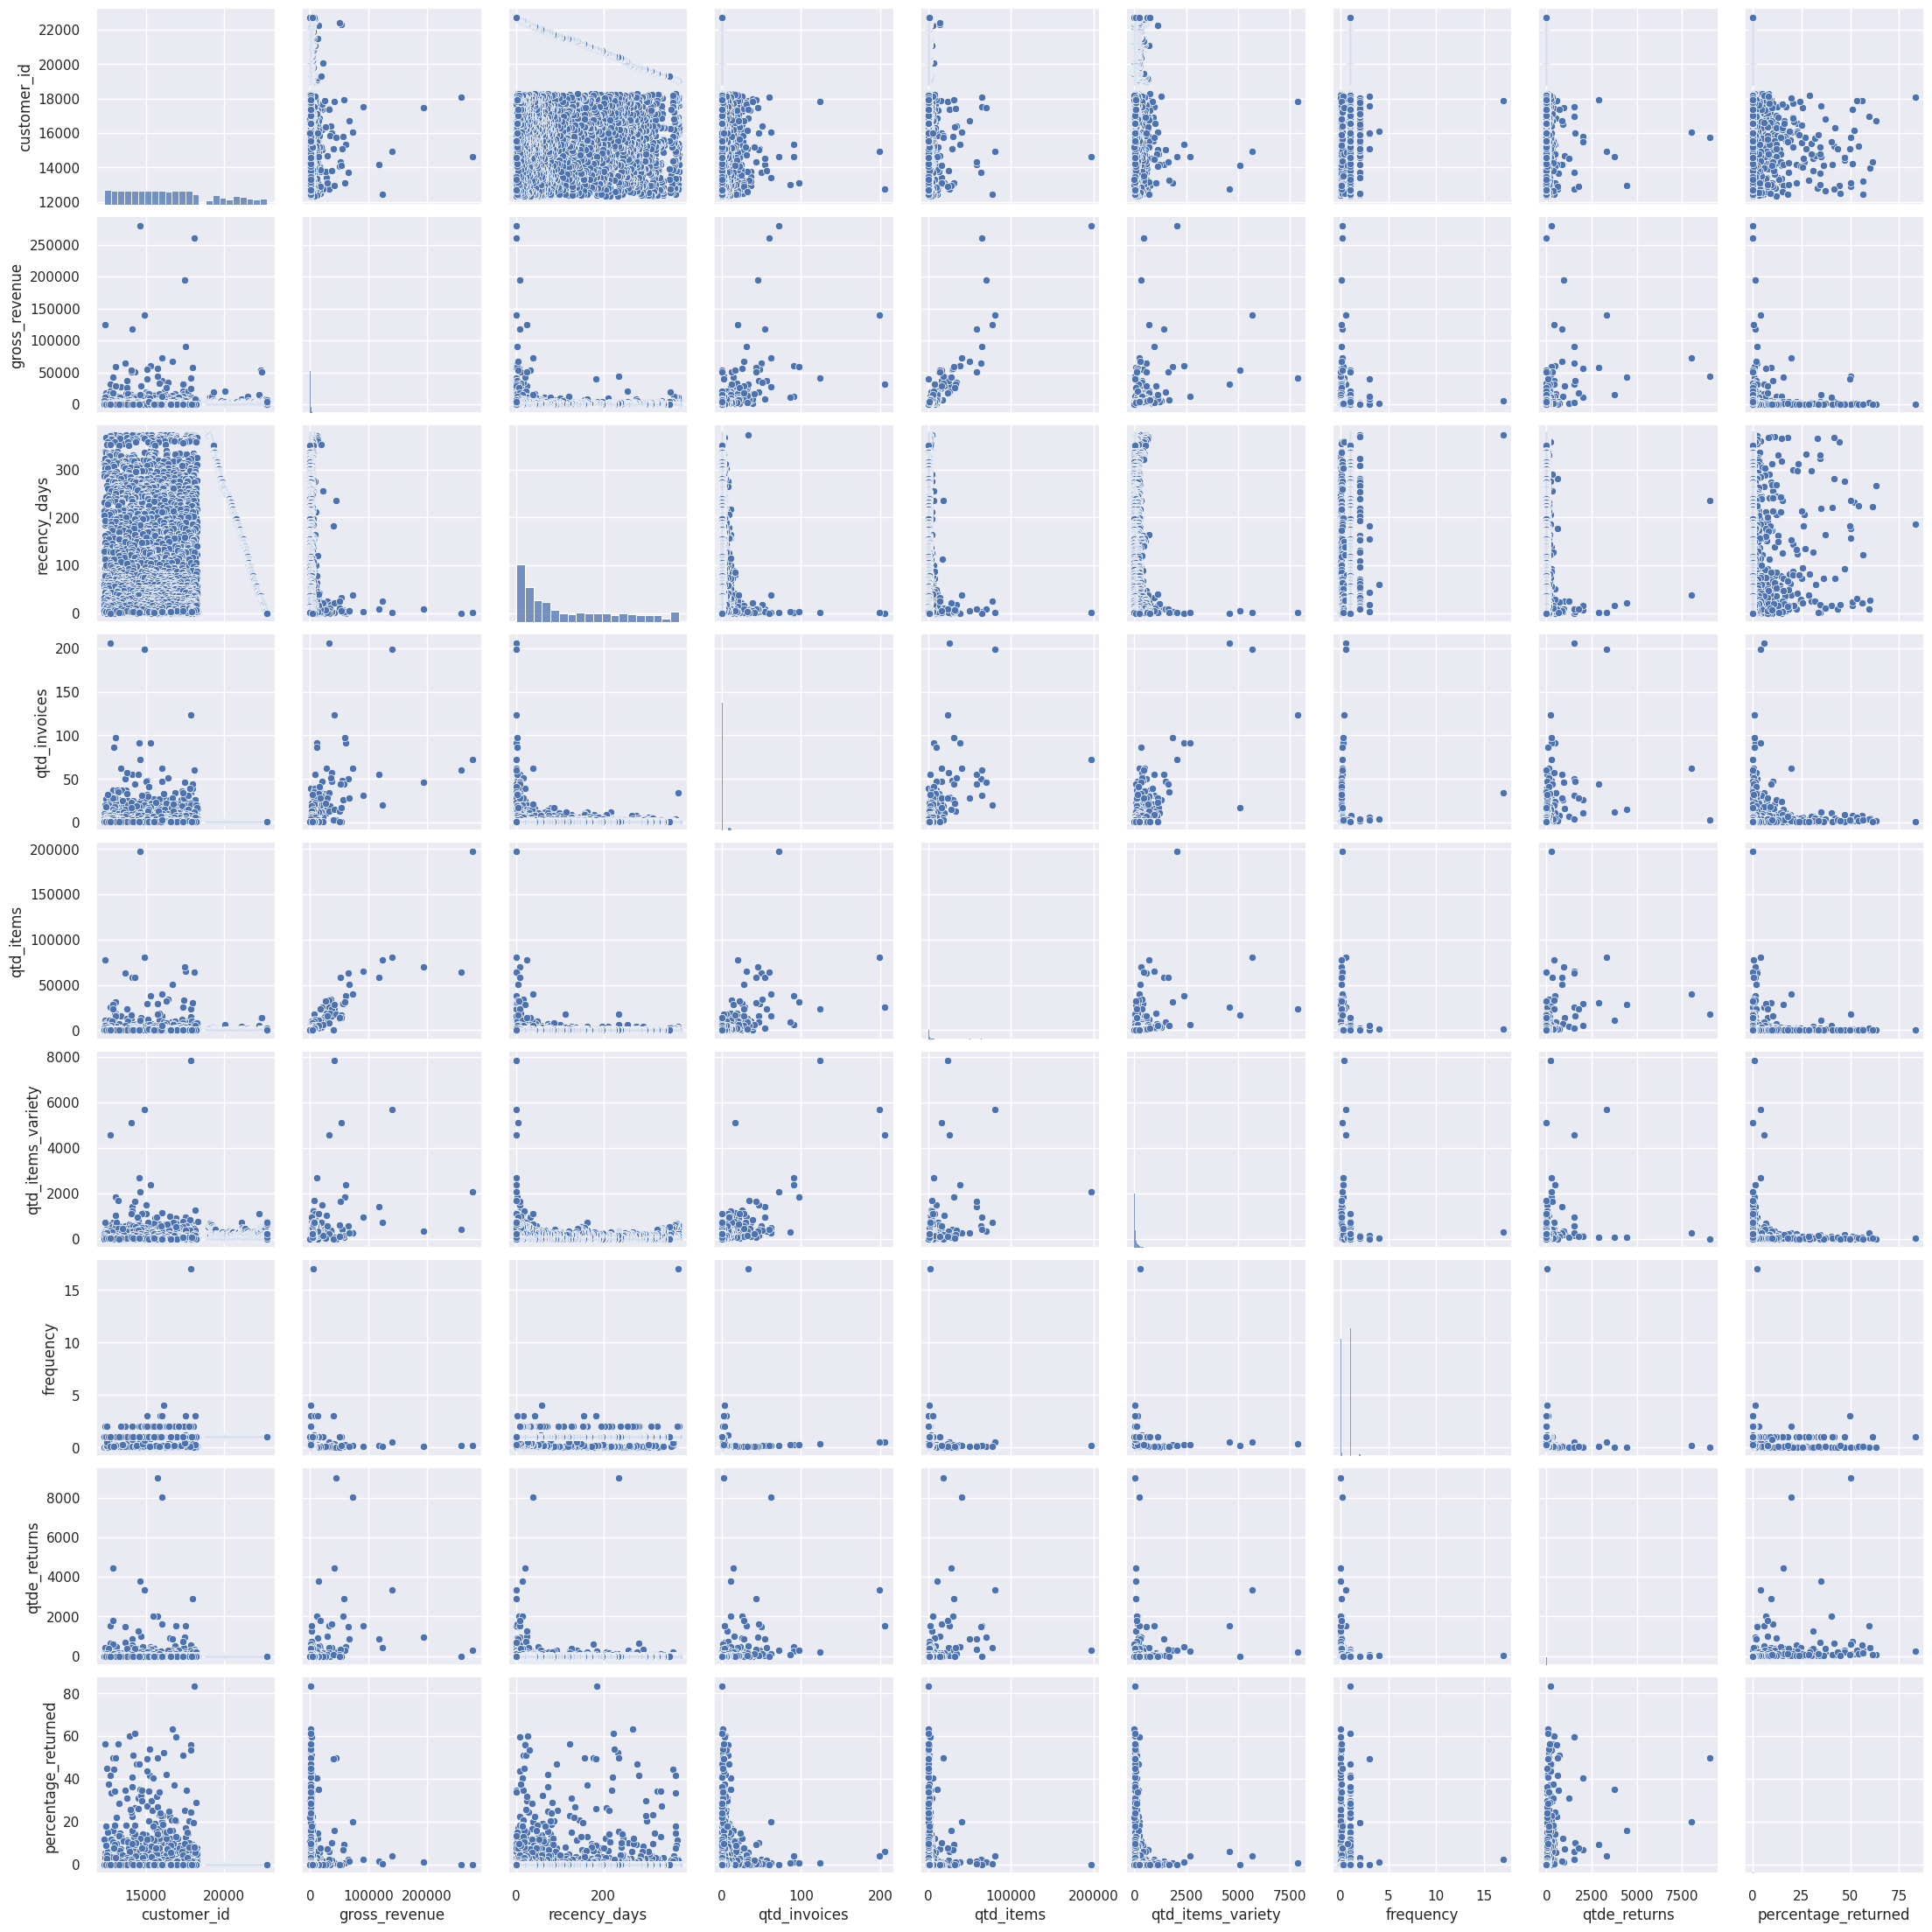

In [57]:
plt.figure(figsize=(12,5))
sns.pairplot(df4)

**Notes**

1. Frequency has low variance
2. Avg ticket has low variance

## 4.3 Space Study

In [52]:
df43 = df4.copy()

In [53]:
mm = pp.MinMaxScaler()

df43['gross_revenue']     = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']      = mm.fit_transform(df43[['recency_days']])
df43['qtd_invoices']      = mm.fit_transform(df43[['qtd_invoices']])
df43['qtd_items']         = mm.fit_transform(df43[['qtd_items']])
df43['qtd_items_variety'] = mm.fit_transform(df43[['qtd_items_variety']])
df43['frequency']         = mm.fit_transform(df43[['frequency']])
df43['qtde_returns']      = mm.fit_transform(df43[['qtde_returns']])
df43['percentage_returned'] = mm.fit_transform(df43[['percentage_returned']])

X = df43.copy()
X = X[['gross_revenue','recency_days','qtd_invoices','qtd_items','qtd_items_variety','frequency','qtde_returns','percentage_returned']]

In [54]:
X.head()

,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned
0,0.019312,0.997319,0.160976,0.008799,0.037770,1.000000,0.004438,0.027698
1,0.011579,0.150134,0.039024,0.007056,0.021692,0.001345,0.003883,0.030216
2,0.024020,0.005362,0.068293,0.025538,0.029476,0.002052,0.005547,0.011933
3,0.003396,0.254692,0.019512,0.002225,0.003445,0.000734,0.000000,0.000000
4,0.003137,0.892761,0.009756,0.000401,0.000255,0.003985,0.002441,0.330000


### 4.3.1 PCA

In [110]:
X.shape

(5679, 8)

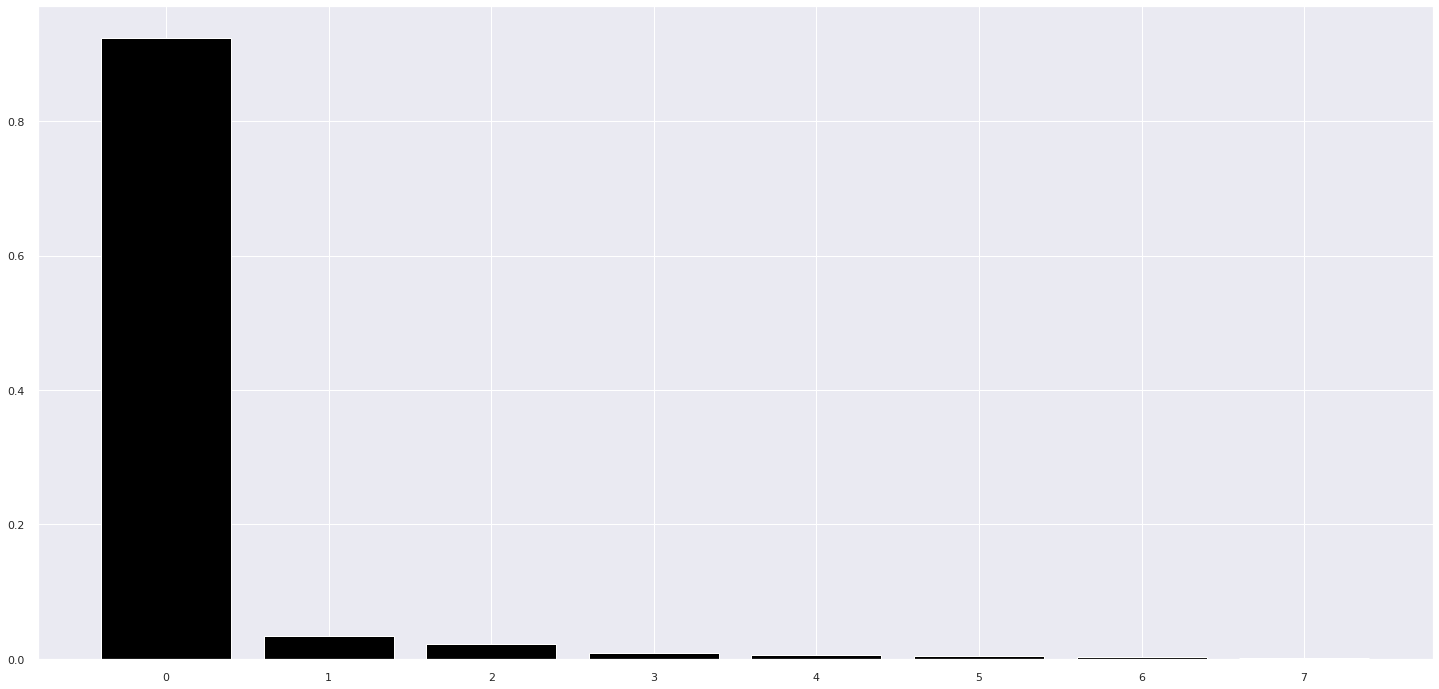

In [111]:
pca = d.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variables
features = range(pca.n_components_)

plt.bar(features,pca.explained_variance_ratio_,color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

## Quais são os componentes com maior variação de dados

<AxesSubplot:xlabel='0', ylabel='1'>

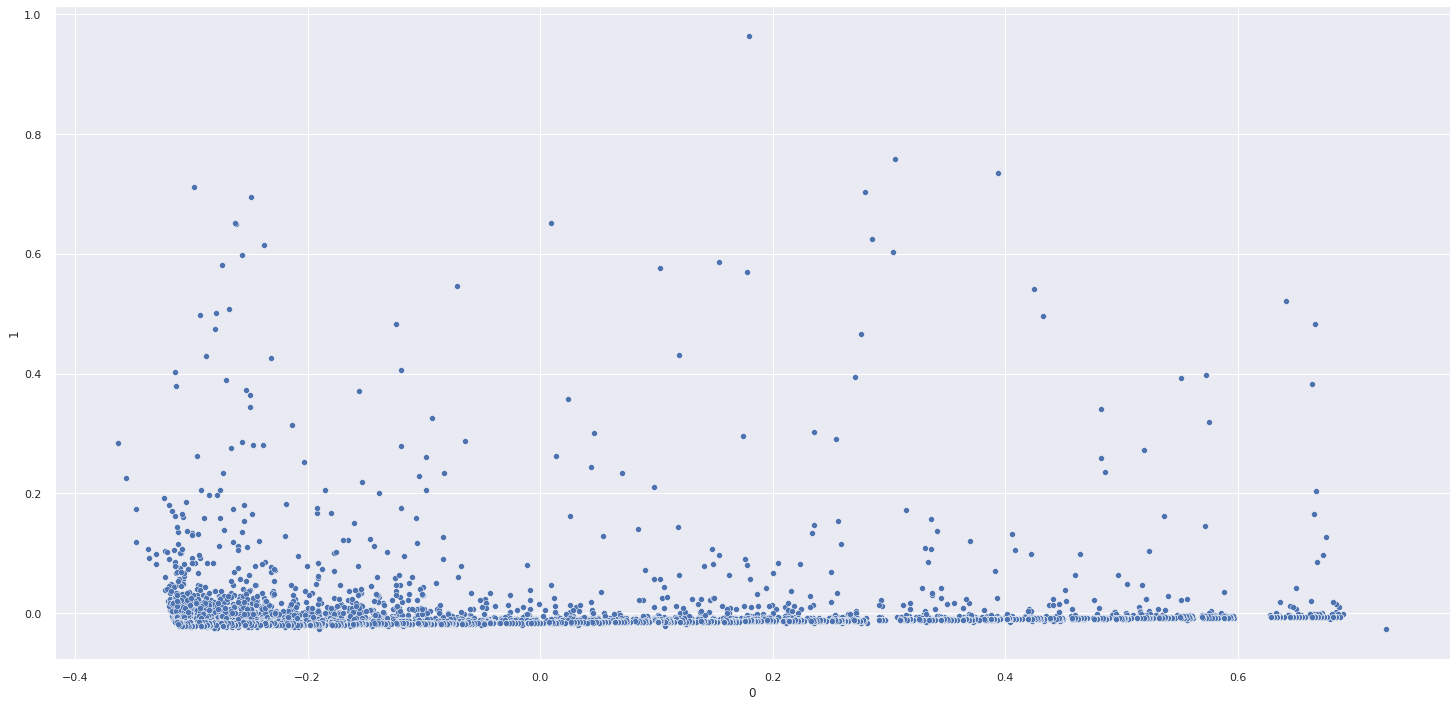

In [112]:
sns.scatterplot(x=0,y=1,data=df_pca)

### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

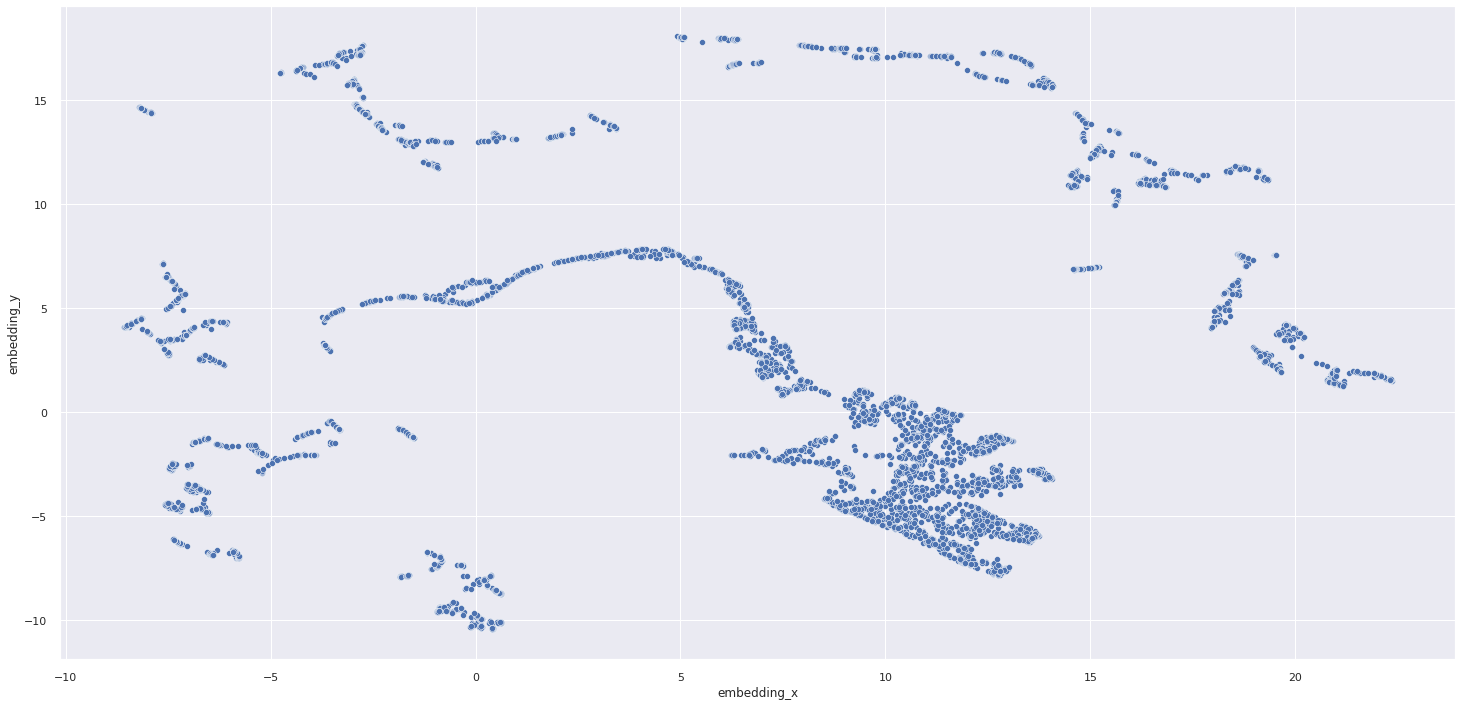

In [113]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_UMAP = pd.DataFrame()
df_UMAP['embedding_x'] = embedding[:,0]
df_UMAP['embedding_y'] = embedding[:,1]

sns.scatterplot(x='embedding_x',y='embedding_y',data=df_UMAP)

### 4.3.3 t-SNE

/home/jordanmalheiros/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jordanmalheiros/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

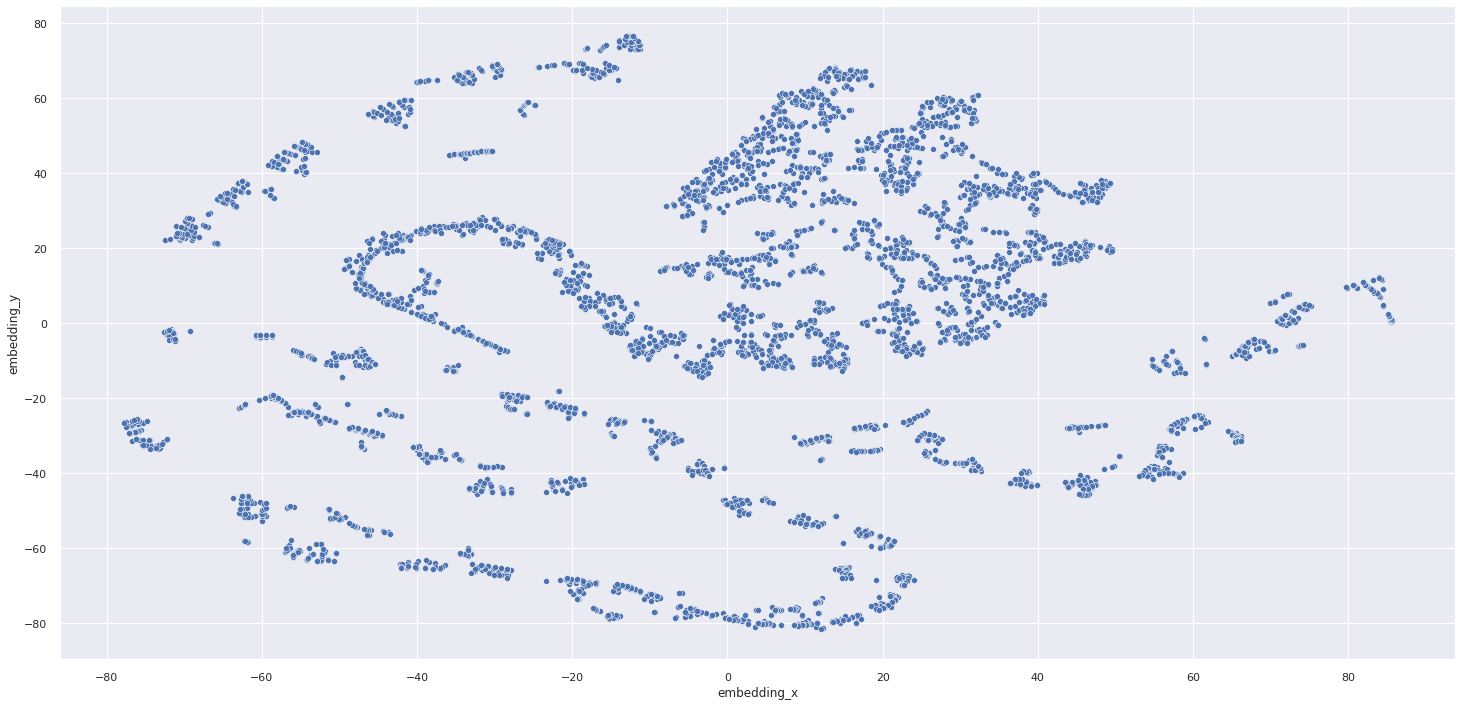

In [114]:
reducer = TSNE(n_components=2,random_state=42,n_jobs=-1)
embedding = reducer.fit_transform(X)

# embedding
df_TSNE = pd.DataFrame()
df_TSNE['embedding_x'] = embedding[:,0]
df_TSNE['embedding_y'] = embedding[:,1]

sns.scatterplot(x='embedding_x',y='embedding_y',data=df_TSNE)

## 4.4 Tree-Based Embedding

In [55]:
df4.head()

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned
0,17850,5391.21,372.0,34.0,1733.0,297.0,17.000000,40.0,2.308136
1,13047,3232.59,56.0,9.0,1390.0,171.0,0.028302,35.0,2.517986
2,12583,6705.38,2.0,15.0,5028.0,232.0,0.040323,50.0,0.994431
3,13748,948.25,95.0,5.0,439.0,28.0,0.017921,0.0,0.000000
4,15100,876.00,333.0,3.0,80.0,3.0,0.073171,22.0,27.500000


In [56]:
# Dataset Definition
y = df4['gross_revenue'].copy()
X = df4[['recency_days','qtd_invoices','qtd_items','qtd_items_variety','frequency','qtde_returns','percentage_returned']]

# Splitting Train and Validation to make a Fine Tuning and also a Feature Selection
x_train, x_validation, y_train,y_validation = ms.train_test_split(X,y,test_size=0.20,random_state=42)

x_train_n = x_train
y_train_n = y_train.values

### 4.4.1 Feature Importance

Feature Ranking
               feature  importance
0            qtd_items    0.807143
0         qtd_invoices    0.055610
0    qtd_items_variety    0.030613
0            frequency    0.030242
0         qtde_returns    0.027034
0  percentage_returned    0.026422
0         recency_days    0.022936


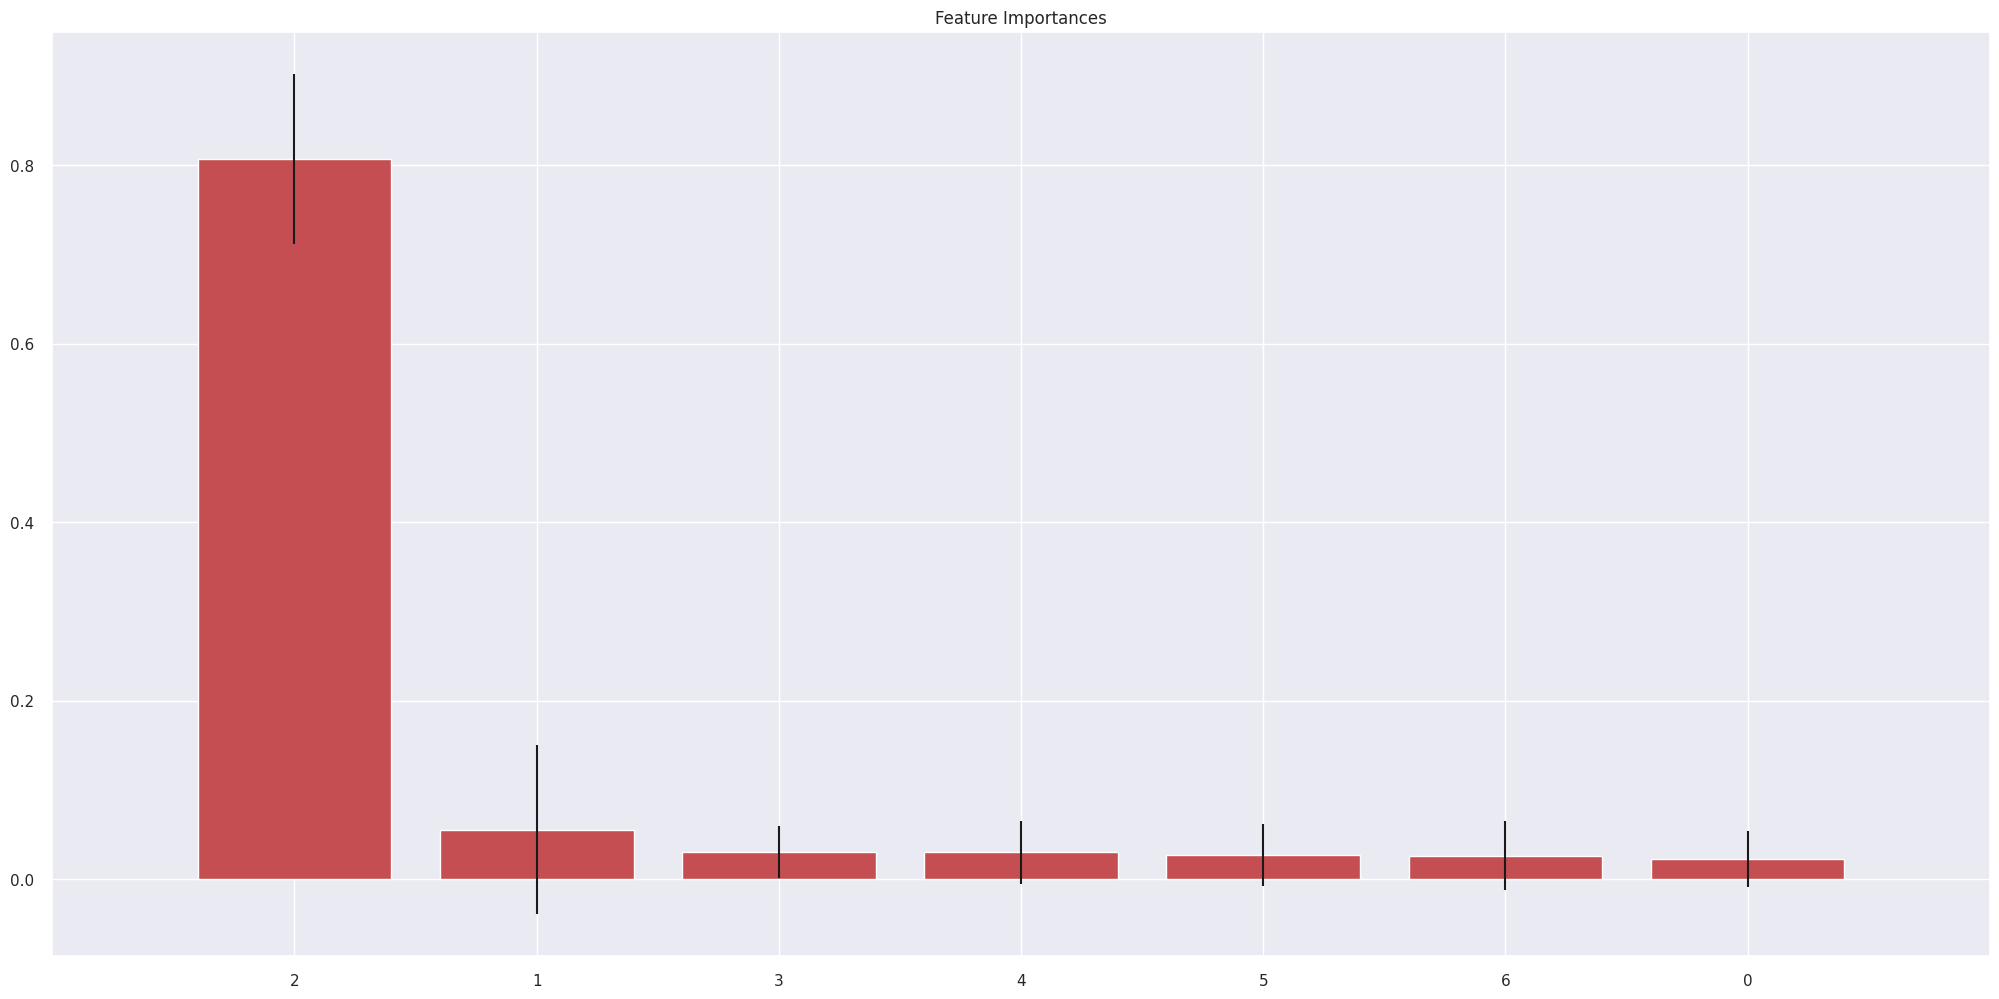

In [57]:
# Model Definition
extratree = ExtraTreesRegressor(n_estimators=250,random_state=0,n_jobs=-1)

# Model Training and Featuring Importance
feature_importance(extratree,x_train_n,y_train_n)


### 4.4.2 HyperParameter Fine Tuning 

In [61]:
# def rf_objective(trial):
    
#     n_estimators = trial.suggest_int('n_estimators',300,2000)
#     #bootstrap = trial.suggest_float()
#     max_depth = trial.suggest_int('max_depth',5,100)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf',1,5)
#     min_samples_split = trial.suggest_int('min_samples_split',2,10)
    
#     rf = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,bootstrap=False,n_jobs=-1,max_features='sqrt').fit(x_train,y_train)
    
#     yhat_rf = rf.predict(x_validation)
    
#     rmse = np.sqrt(mean_squared_error(y_validation,yhat_rf))
#     mae = mean_absolute_error(y_validation,yhat_rf)
#     mape = mean_absolute_percentage_error(y_validation,yhat_rf)
    
    
#     return mae

# study = optuna.create_study(direction='minimize')
# study.optimize(rf_objective,n_trials=500);

# trial = study.best_trial

# print('Best MAE Score: {}'.format(trial.value))
# print('Best hyperparam: {}'.format(trial.params))

In [62]:
# FINAL TUNING PARAMETERS
# {n_estimators=452,max_depth=22,max_features='sqrt', min_samples_leaf=2, min_samples_split=2}
# {'n_estimators': 452, 'max_depth': 22, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}

In [63]:
# Final Evaluation
# Model
rf = RandomForestRegressor(n_estimators=452,max_depth=22,max_features='sqrt', min_samples_leaf=2, min_samples_split=2,n_jobs=-1,random_state=42).fit(x_train,y_train)

# Prediction
yhat_rf = rf.predict(x_validation)

# Perfomance
rf_result = m1_error('Random Forest Regressor',y_validation,yhat_rf)
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,531.545772,0.601924,2229.075616


### 4.4.3 Final Model Tuned and Space Reduce my UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

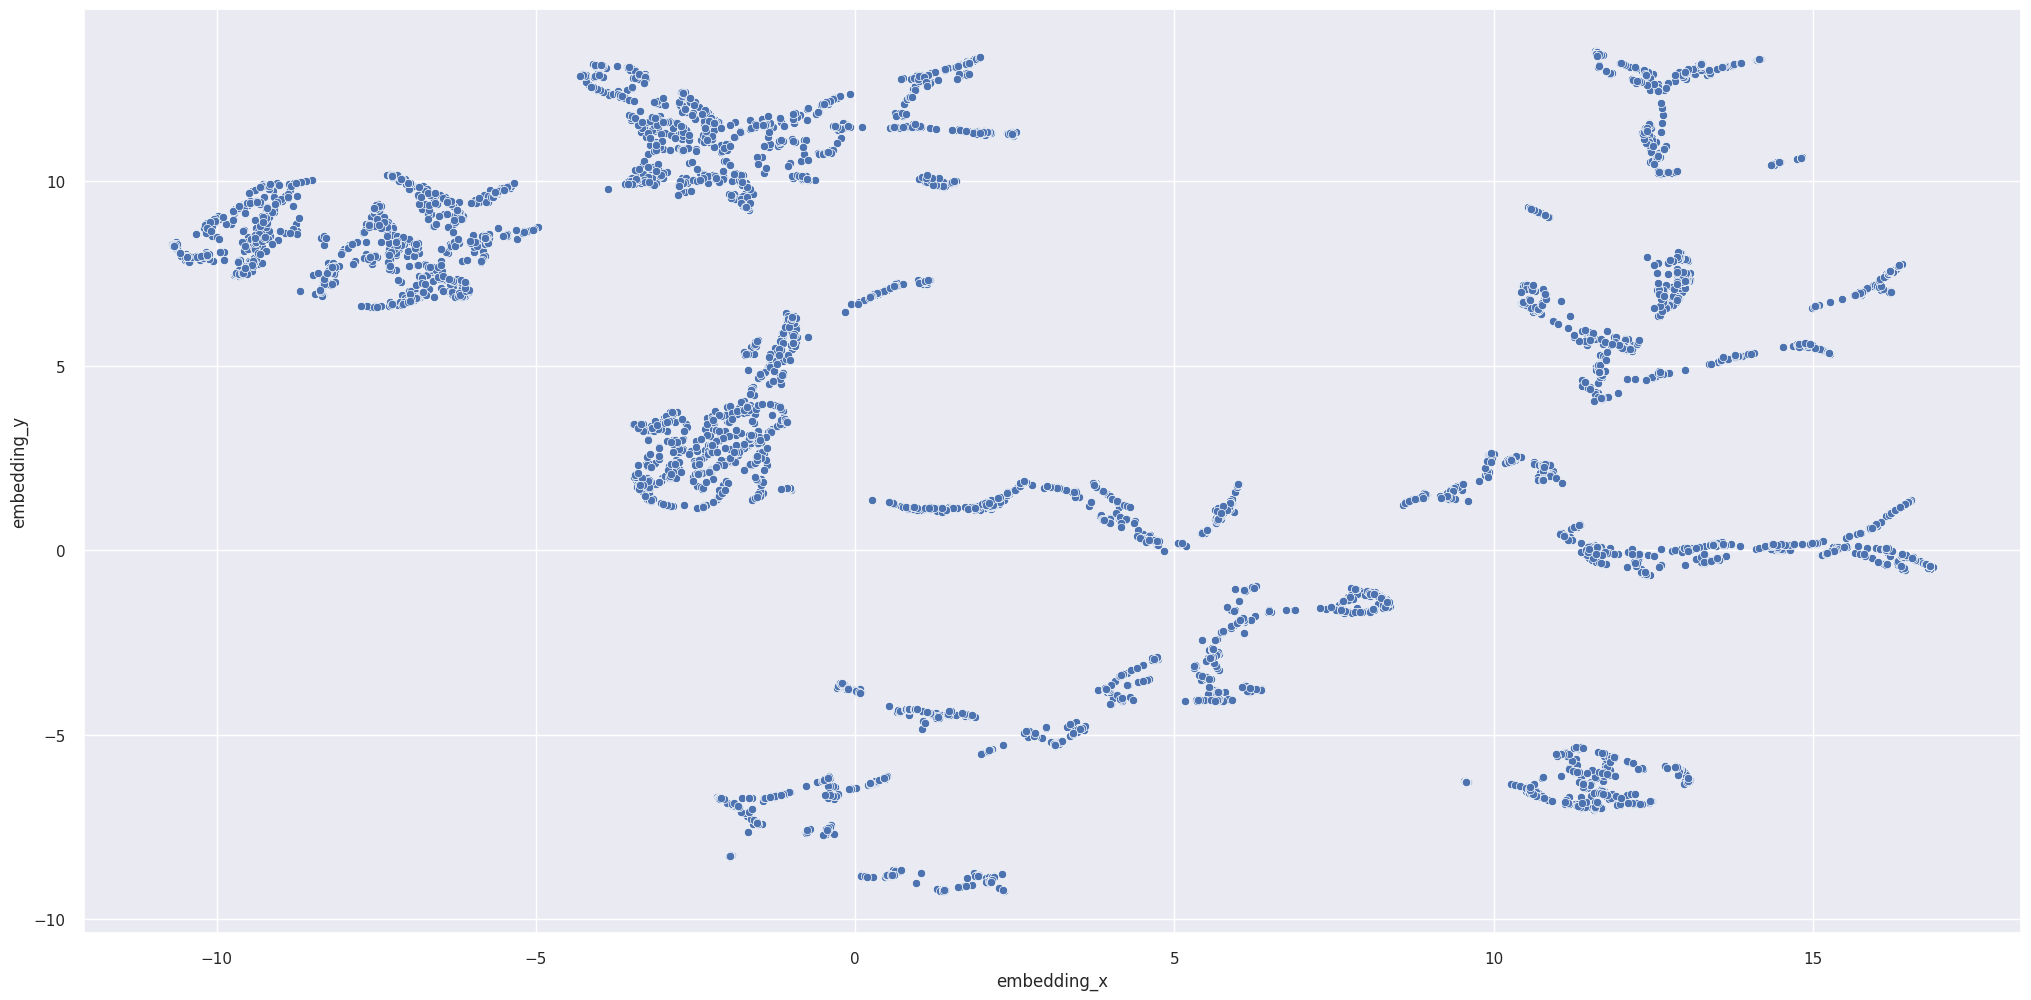

In [58]:
y = df4['gross_revenue']
X = df4[['recency_days','qtd_invoices','qtd_items','qtd_items_variety','frequency','qtde_returns']]

# parametro "tunning"
rf = RandomForestRegressor(n_estimators=452, max_depth=22,max_features='sqrt',random_state=42, min_samples_split=2,min_samples_leaf=1,n_jobs=-1)


# model training
rf.fit(X,y)

df_leaf = pd.DataFrame(rf.apply(X))

reducer = umap.UMAP(n_components=2,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]


sns.scatterplot(x='embedding_x',y='embedding_y',data=df_tree)



In [59]:
X.shape

(5679, 6)


# 5.0 Data Preparation

* Padronização / Normalização ( STANDARDIZATION) -> Premissa de que os dados vieram de uma distribuição normal
* Reescala                    ( RESCALE        ) -> n-Premissa de que os dados vieram de uma distribuição normal

***Regra do Coração***

* 1.0 Distribuição Normal e não possui OUTLIER -> Standard Scaler - Média e desvio padrao

* 2.0 Distribuição Normal e possui Outlier -> Robust Scaler - Quartis

* 3.0 Distribuição Não-Normal -> Min Max Scaler


***Testes de Normalização***
* QQ PLOT  - Quantile Plot ( Quatile teórica x Quantile real )
* KS Teste - Kolgomorov Smirnoff ( Teste de Hipótese) Se p-value > 0.5 -> Distribuição Normal else -> Distrib Não Normal

***Detecção Outlier***
* Boxplot -> Pontos são identificados como Outliers
* IRQ * 2.5 -> Acima disso = OUTLIER

- ***Z-score >   3    -> Outliers***
- ***Z-score <  -3    -> Outliers***

In [60]:
# # df5 = df4.copy()
df5 = df_tree.copy()

In [61]:
# Standart Scaler

# ss = pp.StandardScaler()
# rs = pp.RobustScaler()

In [62]:
# mm = pp.MinMaxScaler()

# df5['gross_revenue'] = mm.fit_transform(df5[['gross_revenue']])
# df5['recency_days'] = mm.fit_transform(df5[['recency_days']])
# df5['qtd_invoices'] =  mm.fit_transform(df5[['qtd_invoices']])
# df5['qtd_items'] = mm.fit_transform(df5[['qtd_items']])
# df5['qtd_items_variety'] = mm.fit_transform(df5[['qtd_items_variety']])
# df5['frequency'] = mm.fit_transform(df5[['frequency']])
# df5['qtde_returns'] = mm.fit_transform(df5[['qtde_returns']])


In [63]:
df5.head()

,embedding_x,embedding_y
0,-7.599470,6.604761
1,-6.919362,6.901824
2,-3.044603,1.879497
3,-3.206161,11.499099
4,-3.208644,11.180527


# 6.0 Feature Selection

In [64]:
df6 = df_tree.copy()

# 7.0 Hyperparameter Fine-Tunning

In [65]:
X = df_tree.copy()

In [66]:
X.head()

,embedding_x,embedding_y
0,-7.599470,6.604761
1,-6.919362,6.901824
2,-3.044603,1.879497
3,-3.206161,11.499099
4,-3.208644,11.180527


In [73]:
clusters = np.arange(2,26,1)

## 7.1 K-Means

In [74]:
kmeans_list = []

for k in clusters:

    # Model Definition
    kmeans_model = KMeans(init='random',n_clusters=k,n_init=100,max_iter=300,random_state=42)


    # Model Training
    kmeans_model.fit(X)

    # Model Predict
    labels = kmeans_model.predict(X)

    # Model Evaluation
    sil = silhouette_score(X,labels,metric='euclidean')
    kmeans_list.append(sil)

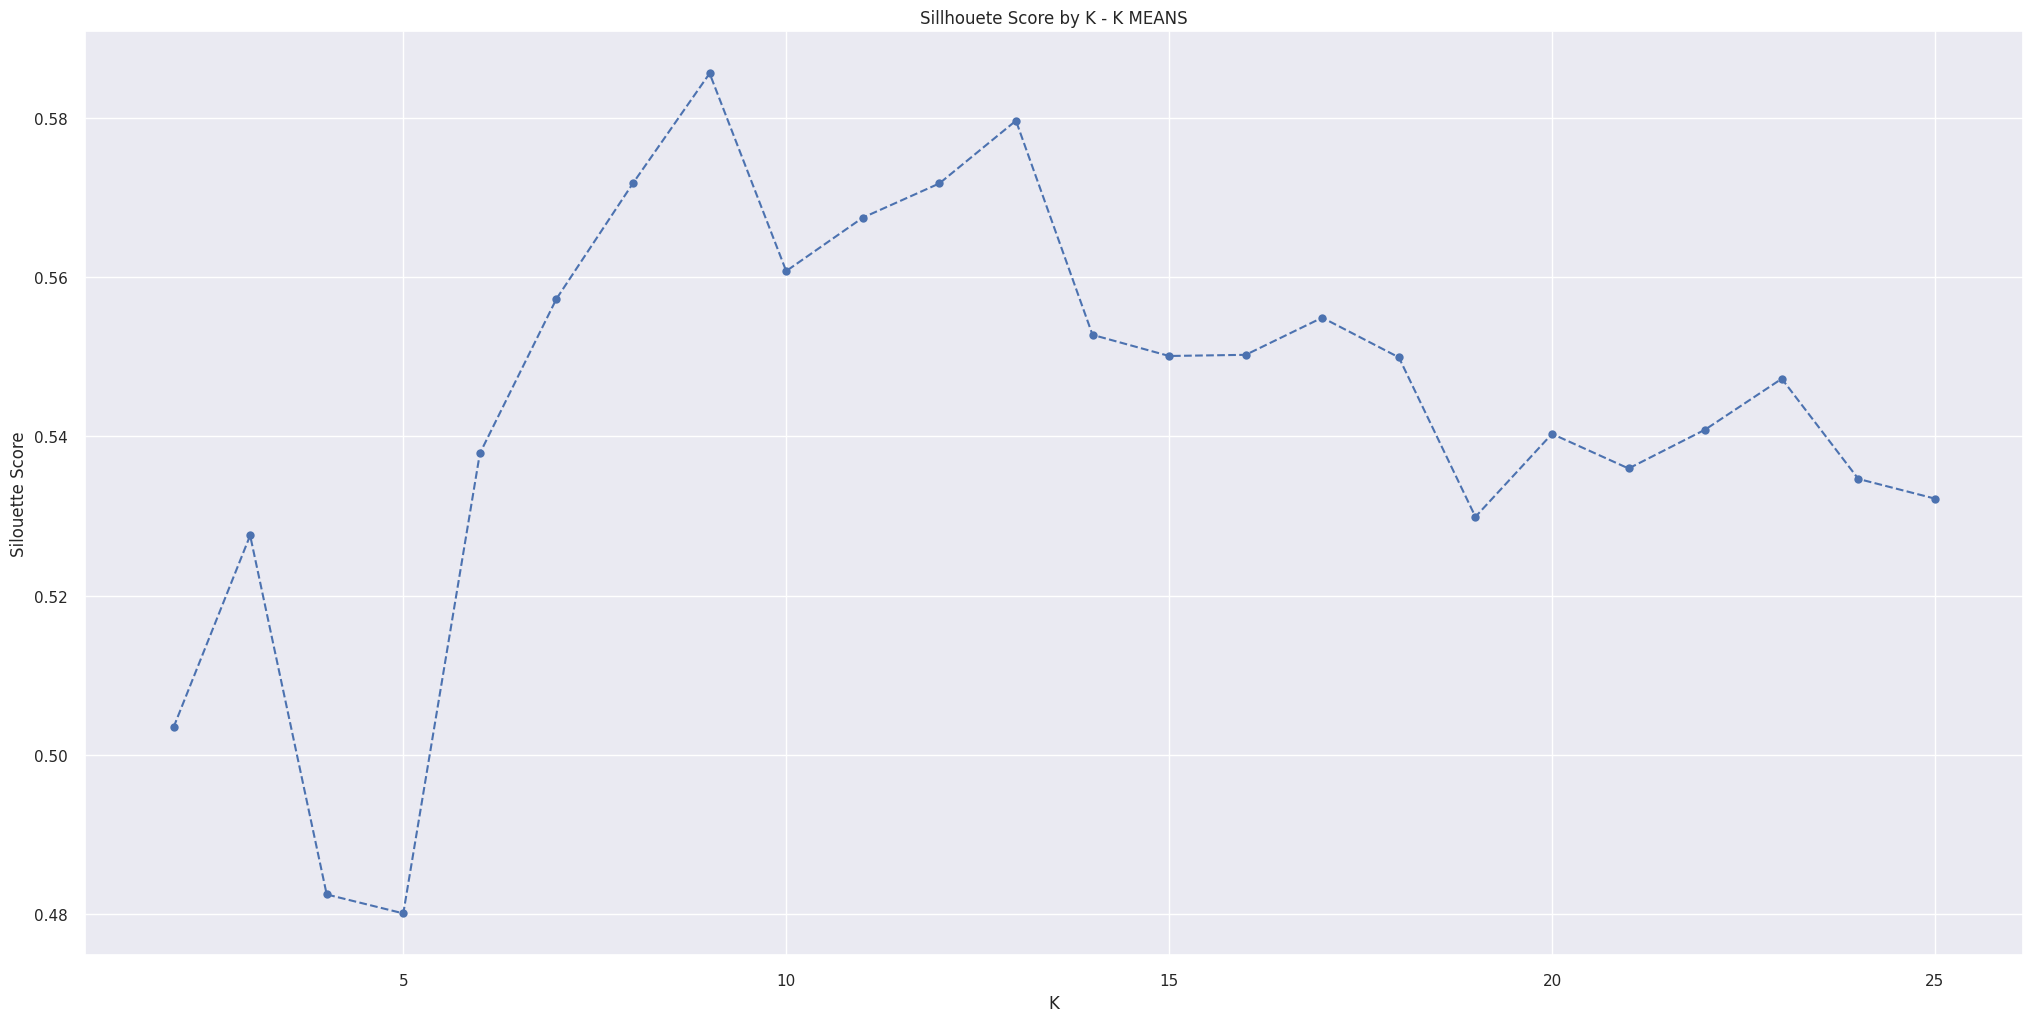

In [75]:
plt.plot(clusters,kmeans_list,linestyle='--',marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silouette Score');
plt.title('Sillhouete Score by K - K MEANS');

## 7.2 GMM


In [76]:
from sklearn.mixture import GaussianMixture

In [77]:
gmm_list = []

for k in clusters:

    # Model Definition
    gmm_model = GaussianMixture(n_components=k,n_init=100,random_state=42)

    # Model Training
    gmm_model.fit(X)

    # Model Predict
    labels = gmm_model.predict(X)

    # Model Evaluation
    sil = silhouette_score(X,labels,metric='euclidean')
    gmm_list.append(sil)

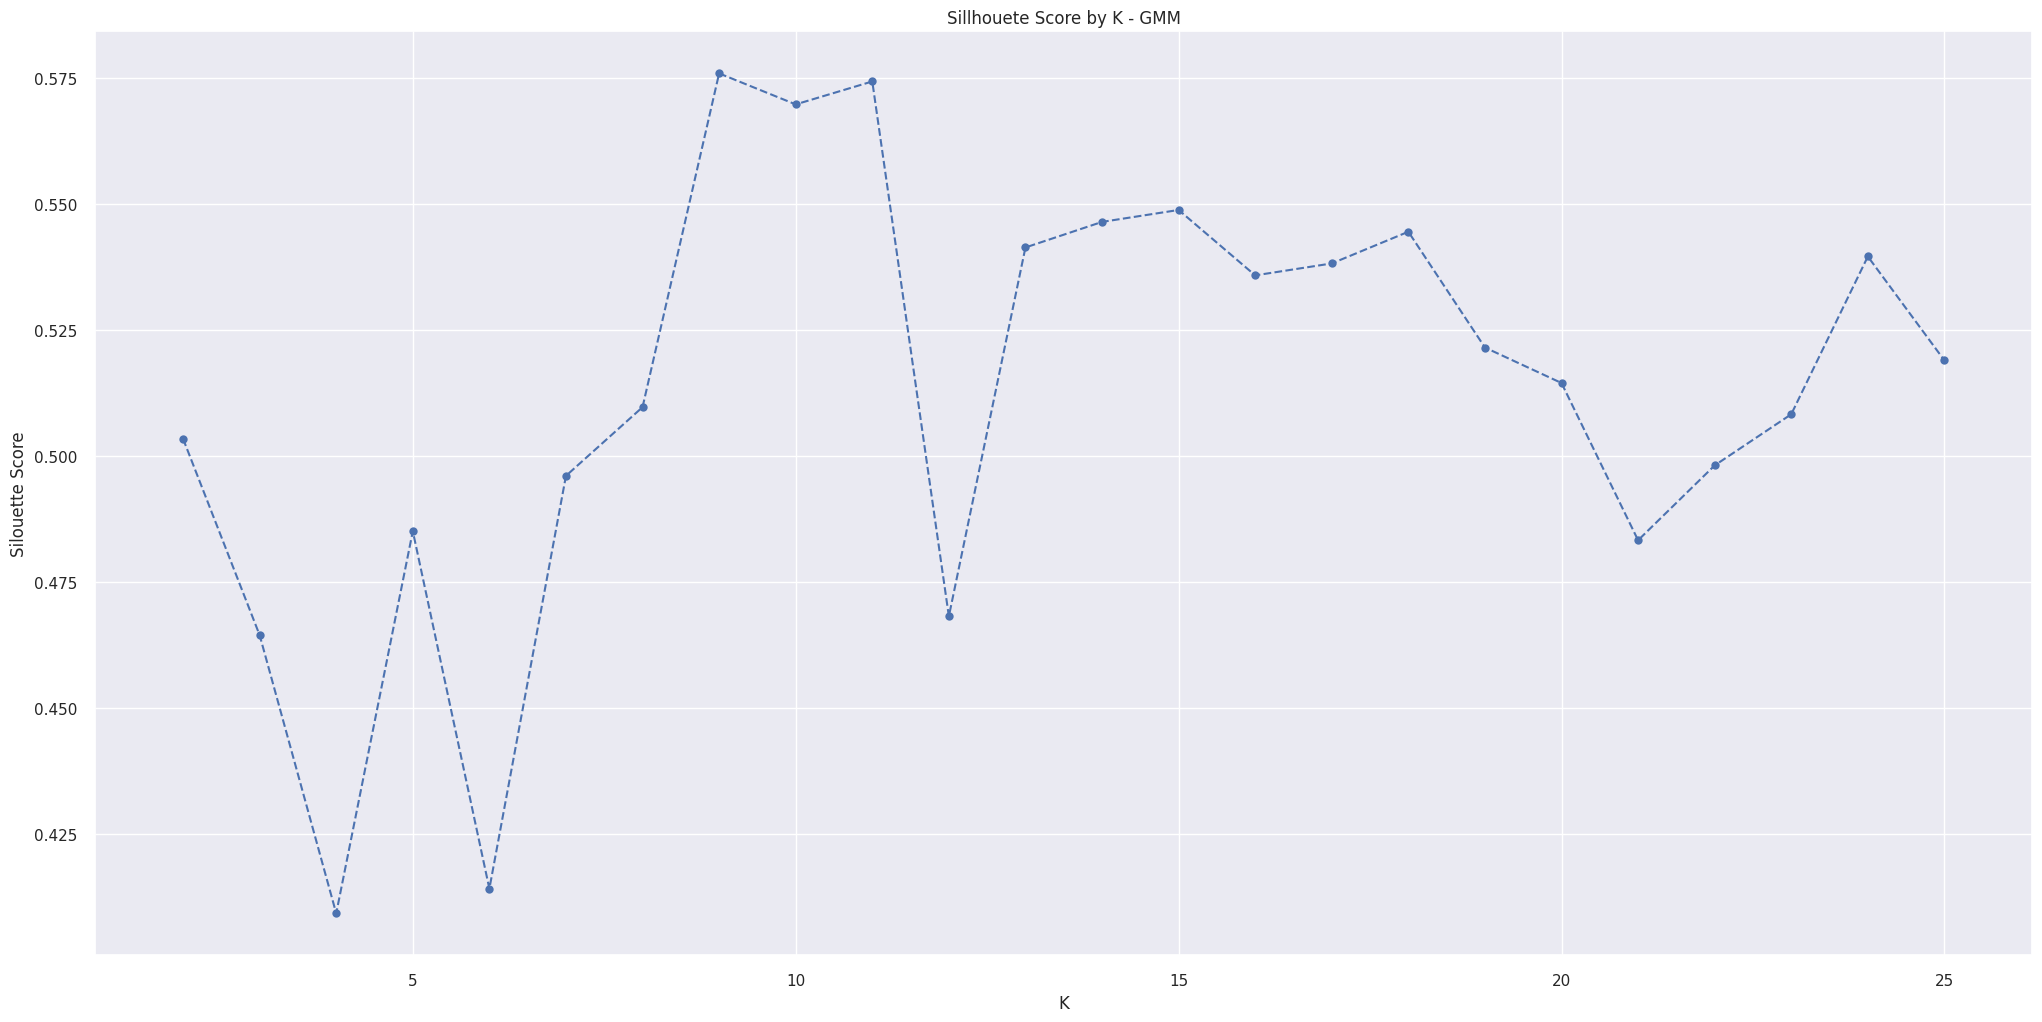

In [78]:
plt.plot(clusters,gmm_list,linestyle='--',marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silouette Score');
plt.title('Sillhouete Score by K - GMM');

## 7.3 Hierarchical Clustering

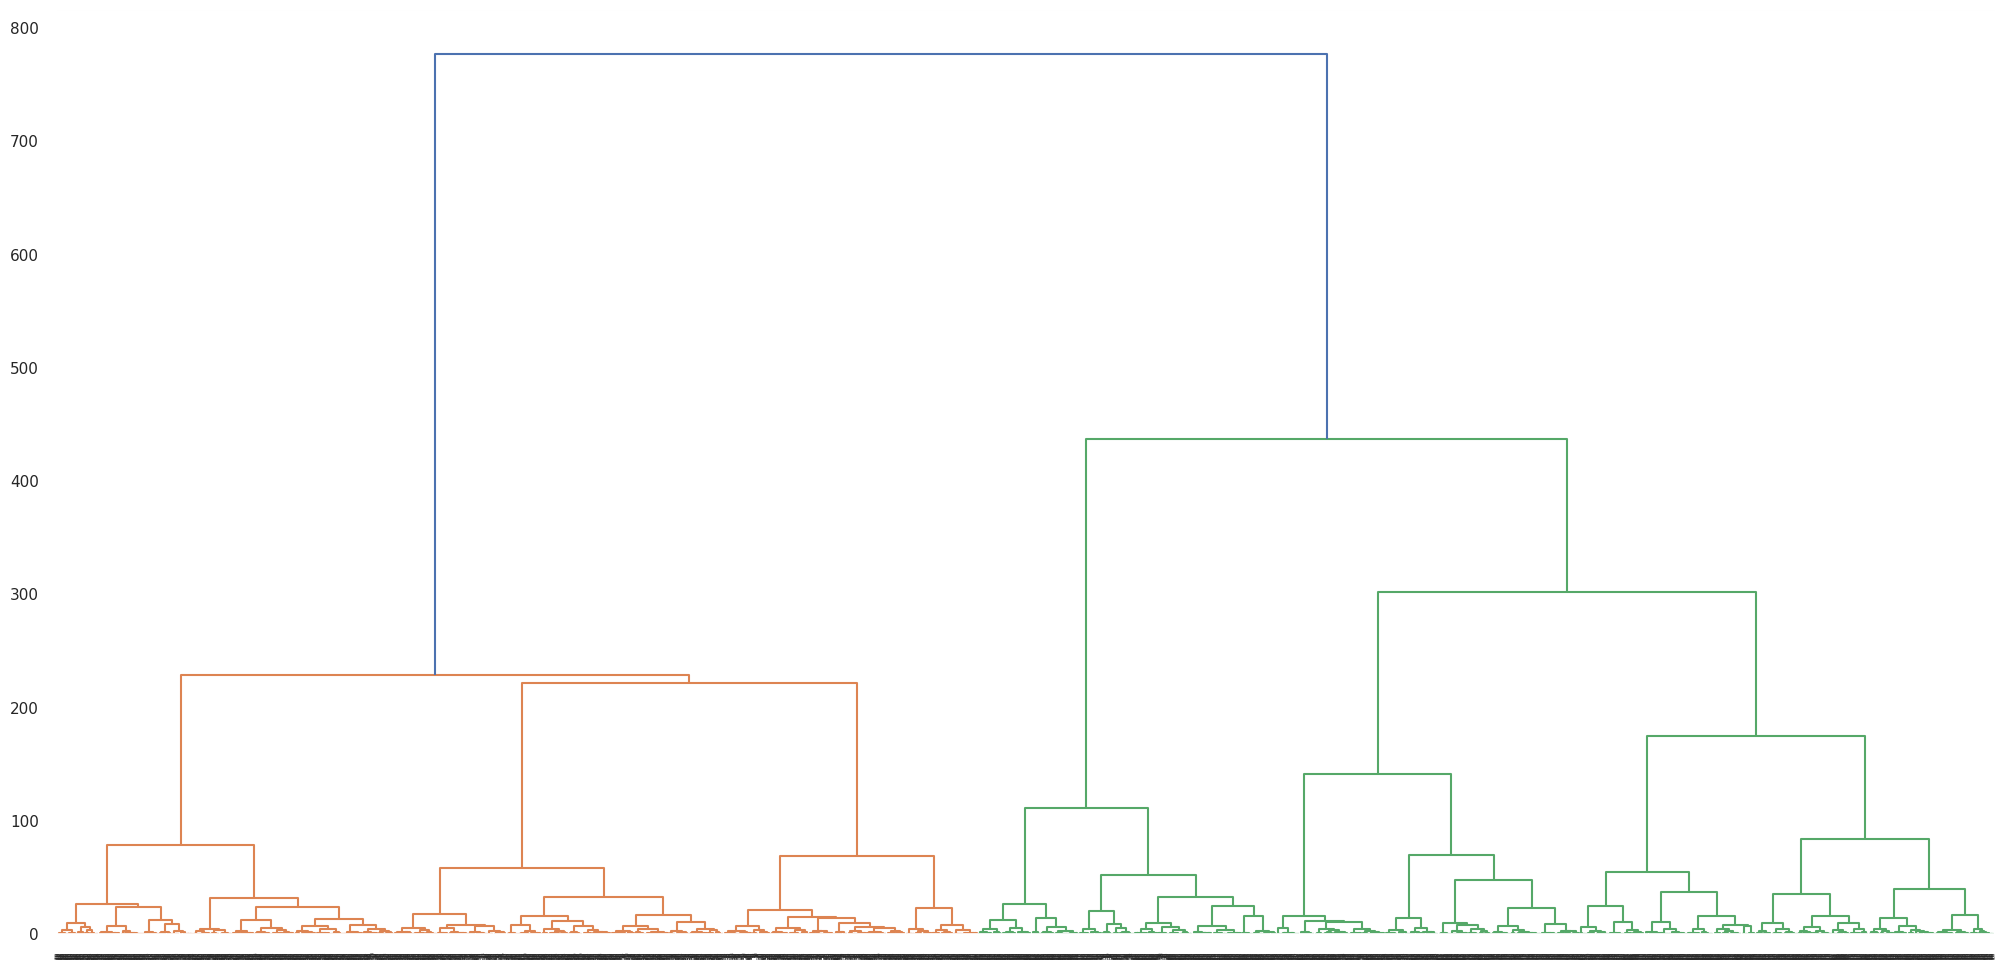

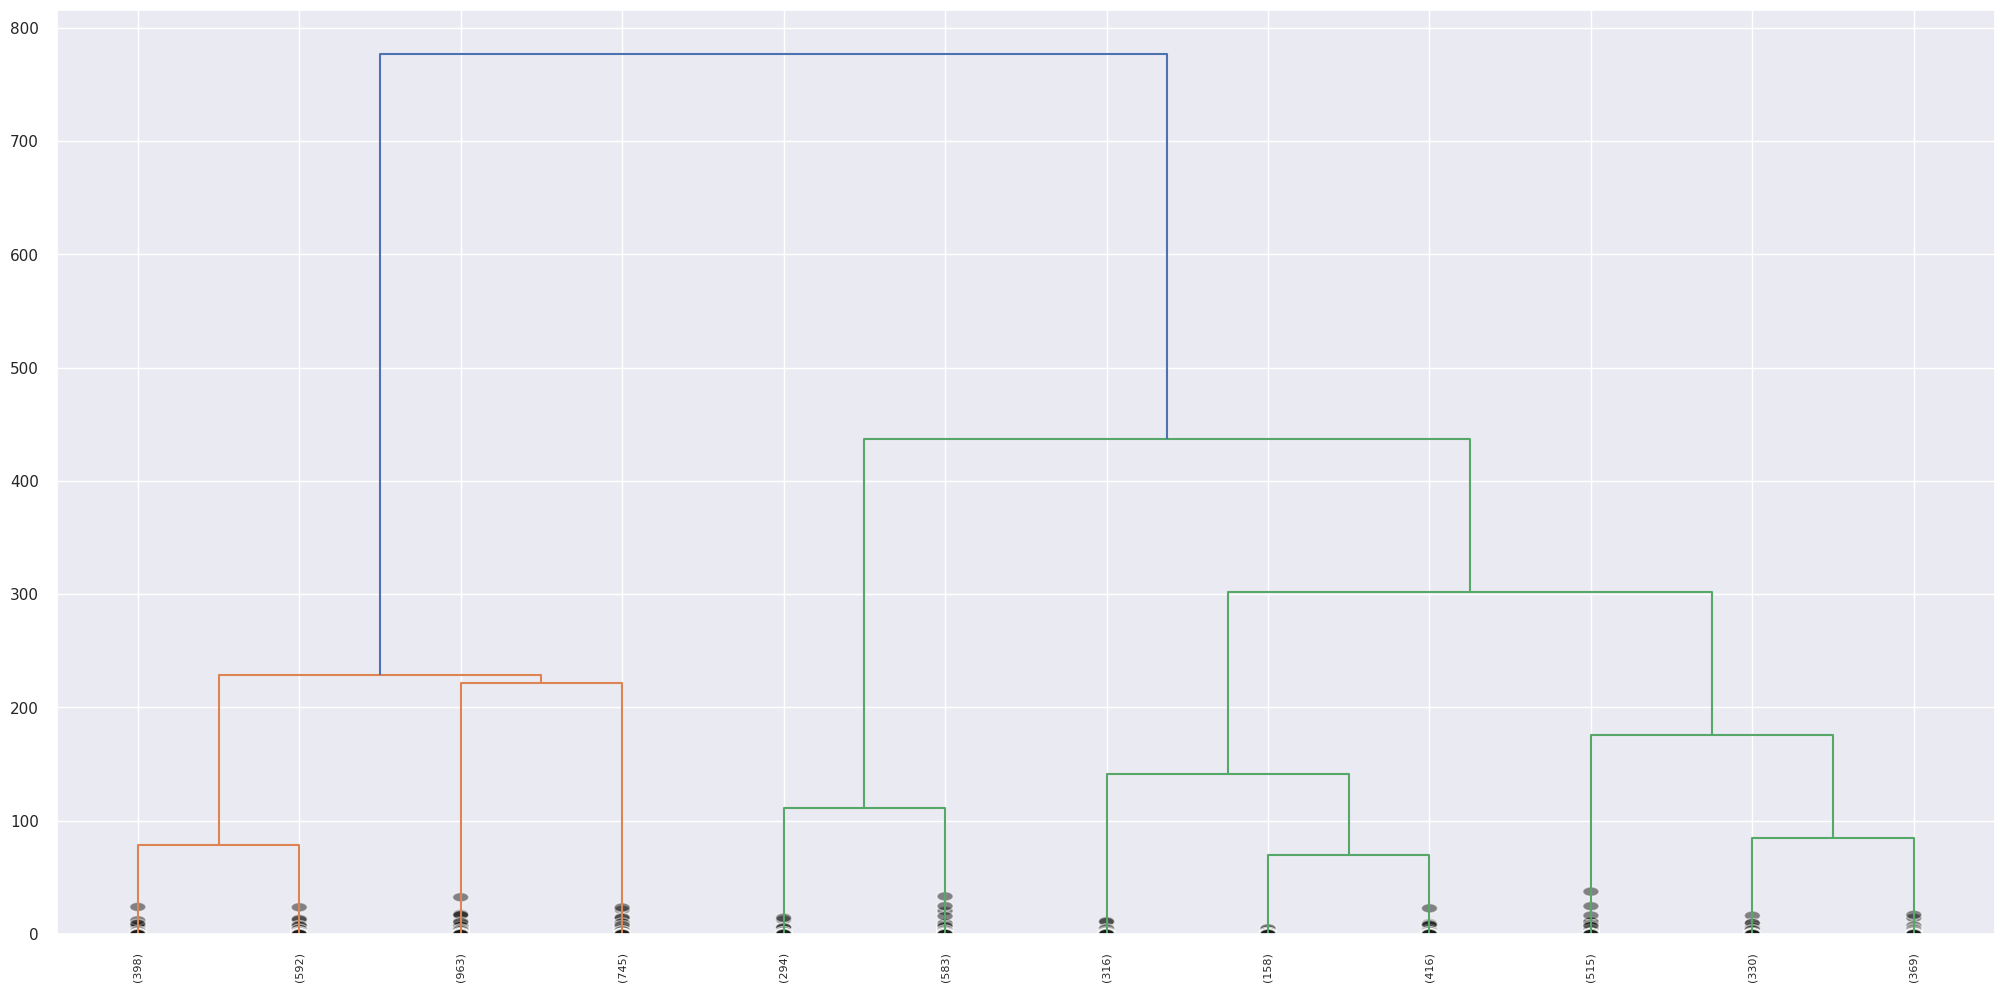

In [79]:
z = linkage(X, method='ward')

dendrogram(z,leaf_rotation=90,leaf_font_size=2)
plt.show()

dendrogram(z,leaf_rotation=90,truncate_mode="lastp",p=12,leaf_font_size=8,show_contracted=True)
plt.show()

### 7.3.1 HClustering Silhouette Score

In [80]:
hcluster_sil = []

for k in clusters:
    

    # Model Definition & Training
    hc_model = linkage(X,'ward')


    # Model Predict
    cluster_labels = fcluster(hc_model, k, criterion="maxclust")

    # Metrics

    sil = silhouette_score(X,cluster_labels,metric='euclidean')
    hcluster_sil.append(sil)

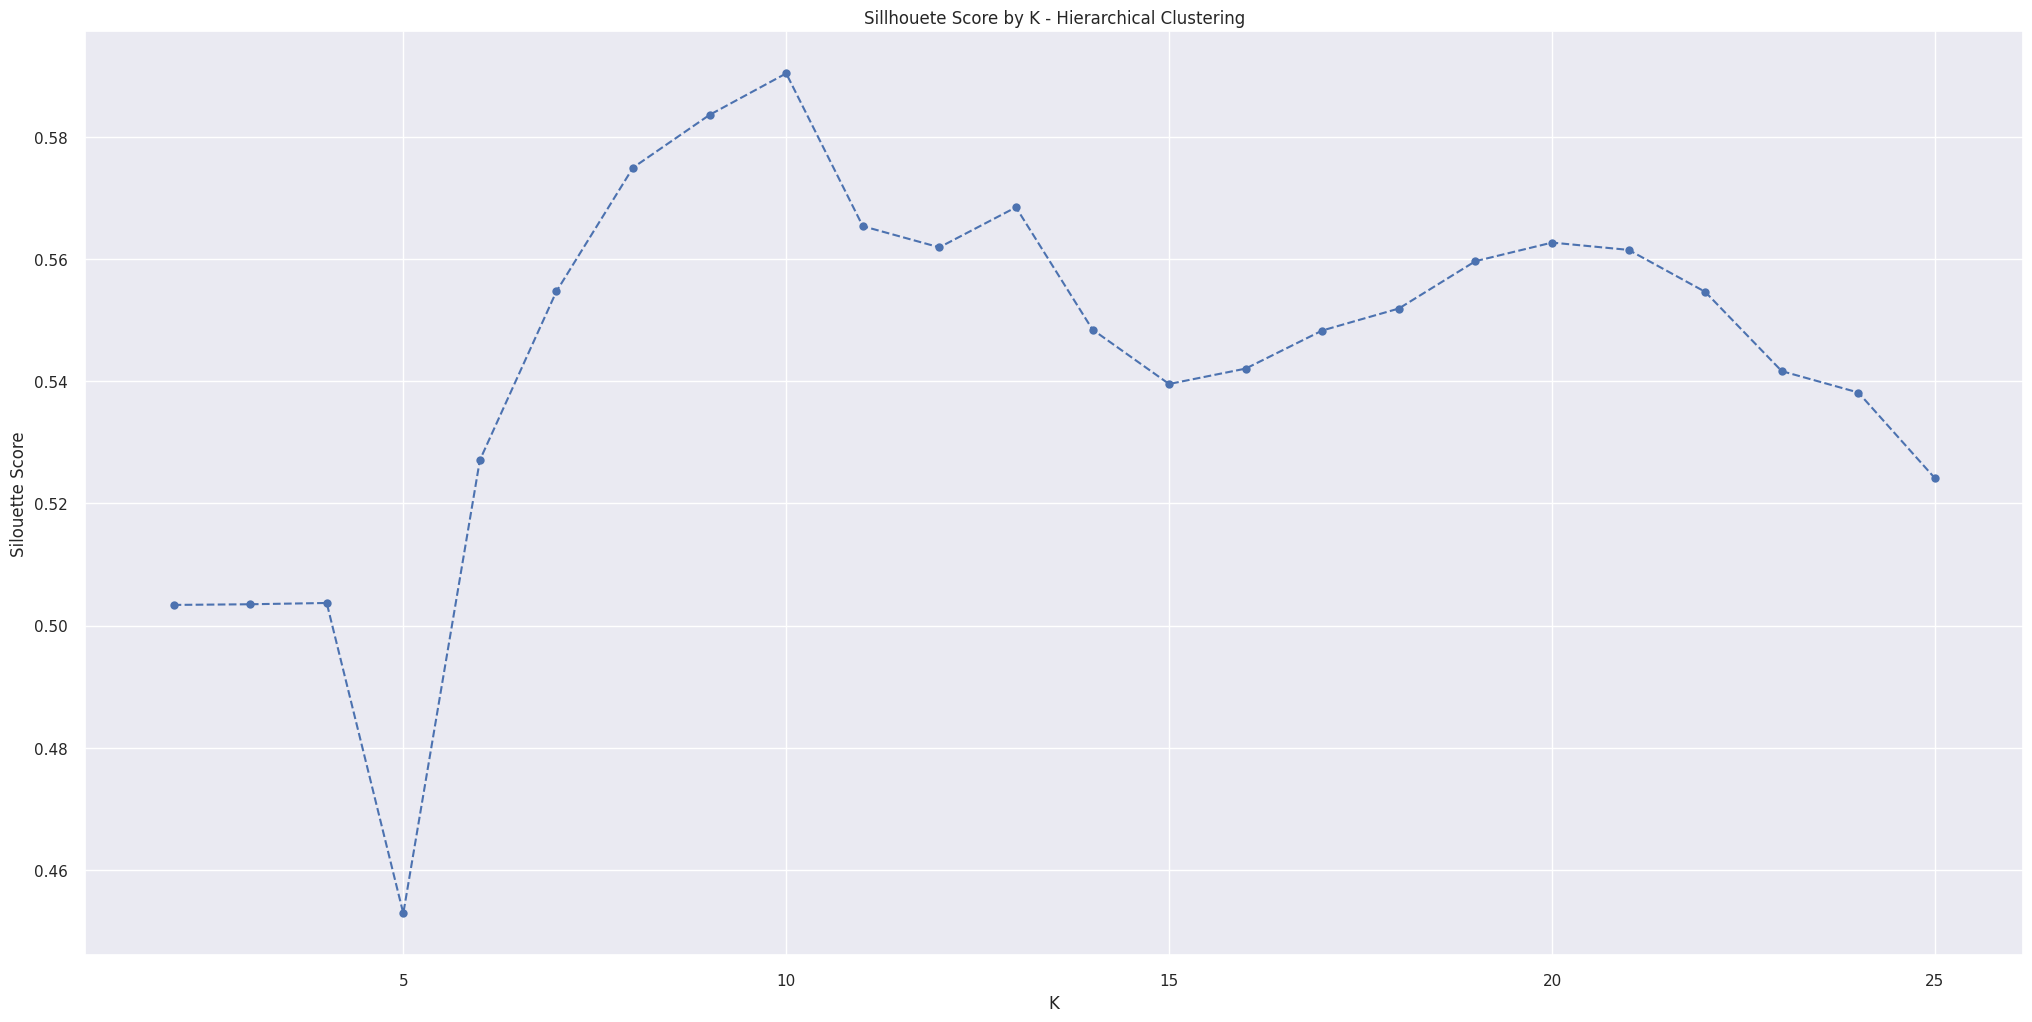

In [81]:
plt.plot(clusters,hcluster_sil,linestyle='--',marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silouette Score');
plt.title('Sillhouete Score by K - Hierarchical Clustering');

## 7.4 DBSCAN

In [156]:
# eps = 1
# min_samples = 20

# # Model Definition'GMM': gmm_list}
# dbscan_model = DBSCAN(eps=eps,min_samples=min_samples)

# # Model Training and predict
# labels = dbscan_model.fit_predict(X)

# # Silhouette
# sil = silhouette_score(X,labels,metric='euclidean')
# print('For {} clusters - Silhouette Score:{}'.format(len(np.unique(labels)-1),sil))
# print(np.unique(labels))

## 7.5 Silhouette Score

In [83]:
clusters_selected = [2,3, 4, 5, 6, 7, 8,9,10,11]

 For K = 2. Silhouette Score: 0.503372848033905
 For K = 3. Silhouette Score: 0.5034813284873962
 For K = 4. Silhouette Score: 0.5036909580230713
 For K = 5. Silhouette Score: 0.45283937454223633
 For K = 6. Silhouette Score: 0.5271039605140686
 For K = 7. Silhouette Score: 0.554742157459259
 For K = 8. Silhouette Score: 0.5750107169151306
 For K = 9. Silhouette Score: 0.5836569666862488
 For K = 10. Silhouette Score: 0.5904486775398254
 For K = 11. Silhouette Score: 0.5654206871986389


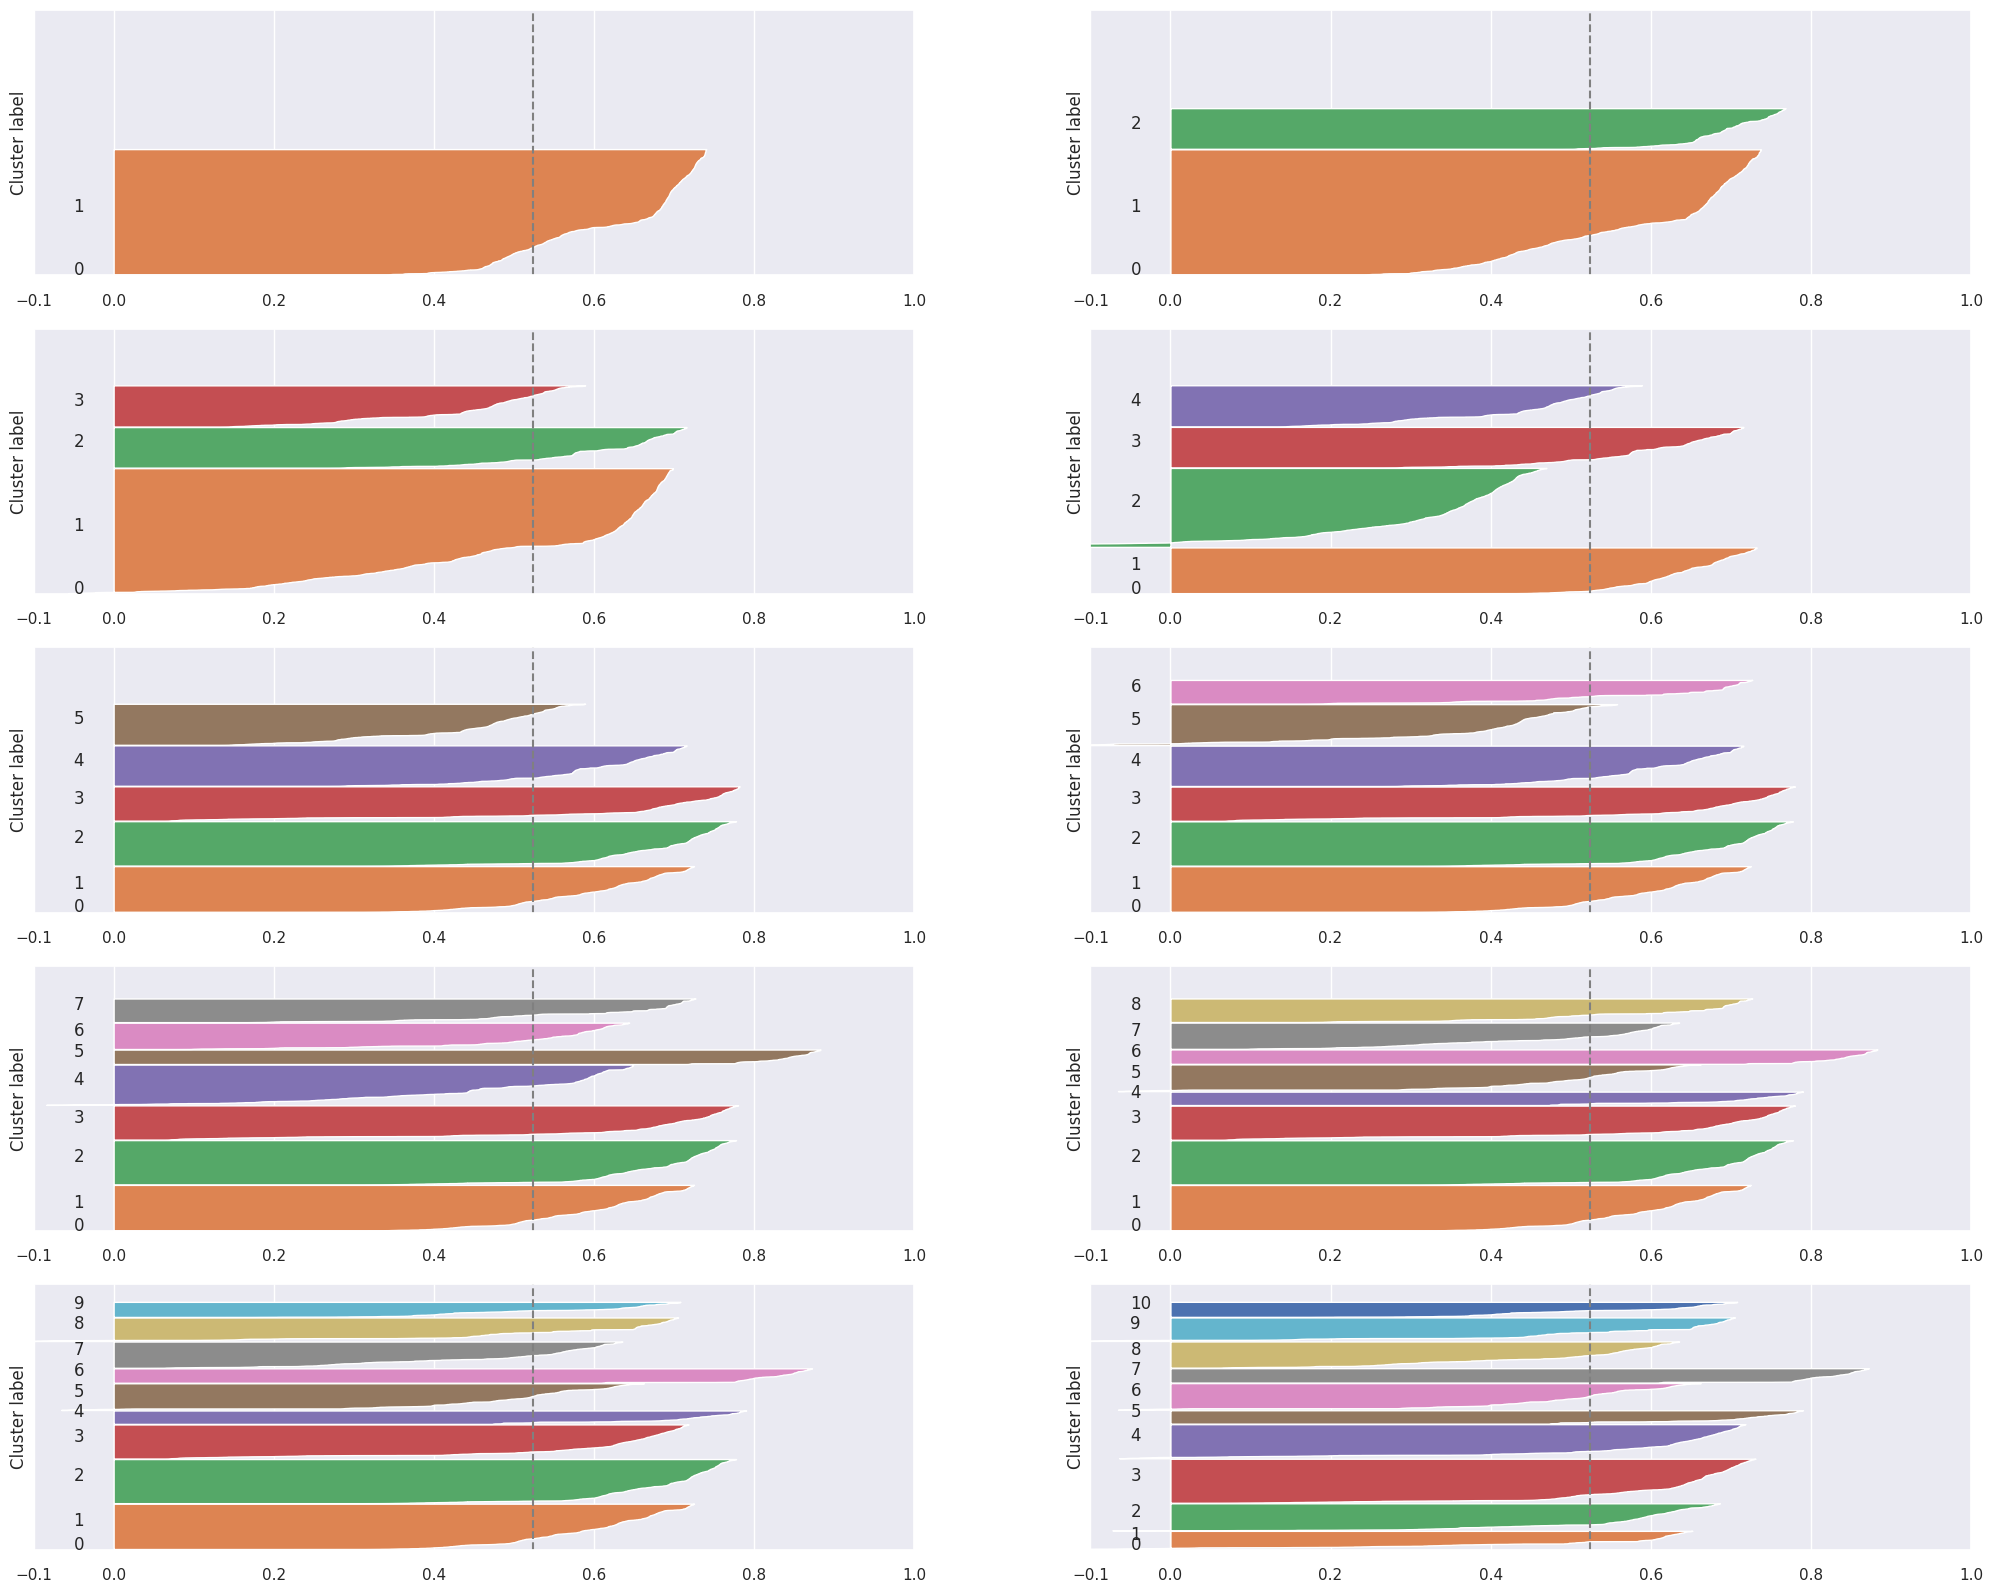

In [84]:
#evaluating HC here:
fig, ax = plt.subplots( 5, 2 )
fig.set_size_inches( 25, 20 )

#for k in clusters_em:
for k in clusters_selected:
    #position to plot
    q, mod = divmod( k, 2 )
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = linkage( X, 'ward' )

    # model predict
    labels = fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    #get silhouette values of each sample
    samples_silhouette_values = silhouette_samples( X, labels )

    #space between clusters
    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # define colors range
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        ax[q-1,mod].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10
        
        
    ax[q-1,mod].set_ylabel("Cluster label")
    
    ax[q-1,mod].axvline(x=sil, color="gray", linestyle="--")

    
    ax[q-1,mod].set_yticks([])
    ax[q-1,mod].set_xticks([-0.1,0, 0.2, 0.4, 0.6, 0.8, 1])


## 7.6 Results

In [82]:
df_results = pd.DataFrame({'KMeans':kmeans_list,
                           'GMM': gmm_list,
                           'HC': hcluster_sil}).T

df_results.columns = clusters
df_results.style.highlight_max(color='red',axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
KMeans,0.503488,0.527573,0.482500,0.480124,0.537878,0.557283,0.571805,0.585586,0.560766,0.567473,0.571770,0.579646,0.552762,0.550107,0.550252,0.554920,0.549934,0.529913,0.540328,0.535982,0.540864,0.547250,0.534673,0.532200
GMM,0.503373,0.464394,0.409155,0.485029,0.414052,0.496010,0.509647,0.575904,0.569748,0.574303,0.468129,0.541346,0.546422,0.548791,0.535809,0.538177,0.544470,0.521486,0.514440,0.483223,0.498082,0.508237,0.539556,0.518922
HC,0.503373,0.503481,0.503691,0.452839,0.527104,0.554742,0.575011,0.583657,0.590449,0.565421,0.561950,0.568514,0.548475,0.539564,0.542087,0.548328,0.551930,0.559684,0.562730,0.561533,0.554663,0.541671,0.538166,0.524130


In [228]:
clusters = [2,3,4,5,6,7,8,9,10]

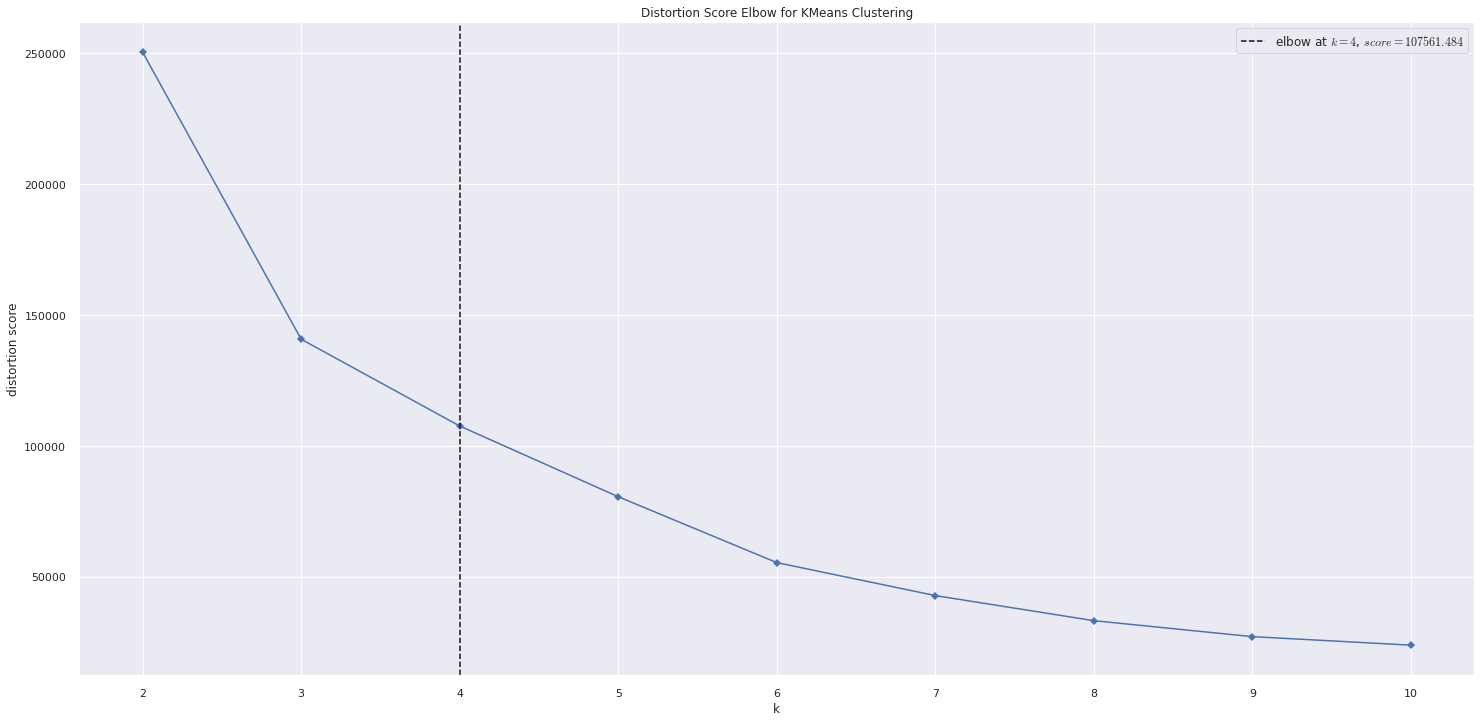

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [229]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(KMeans(),k=clusters,timings=False)
kmeans.fit(X)
kmeans.show()

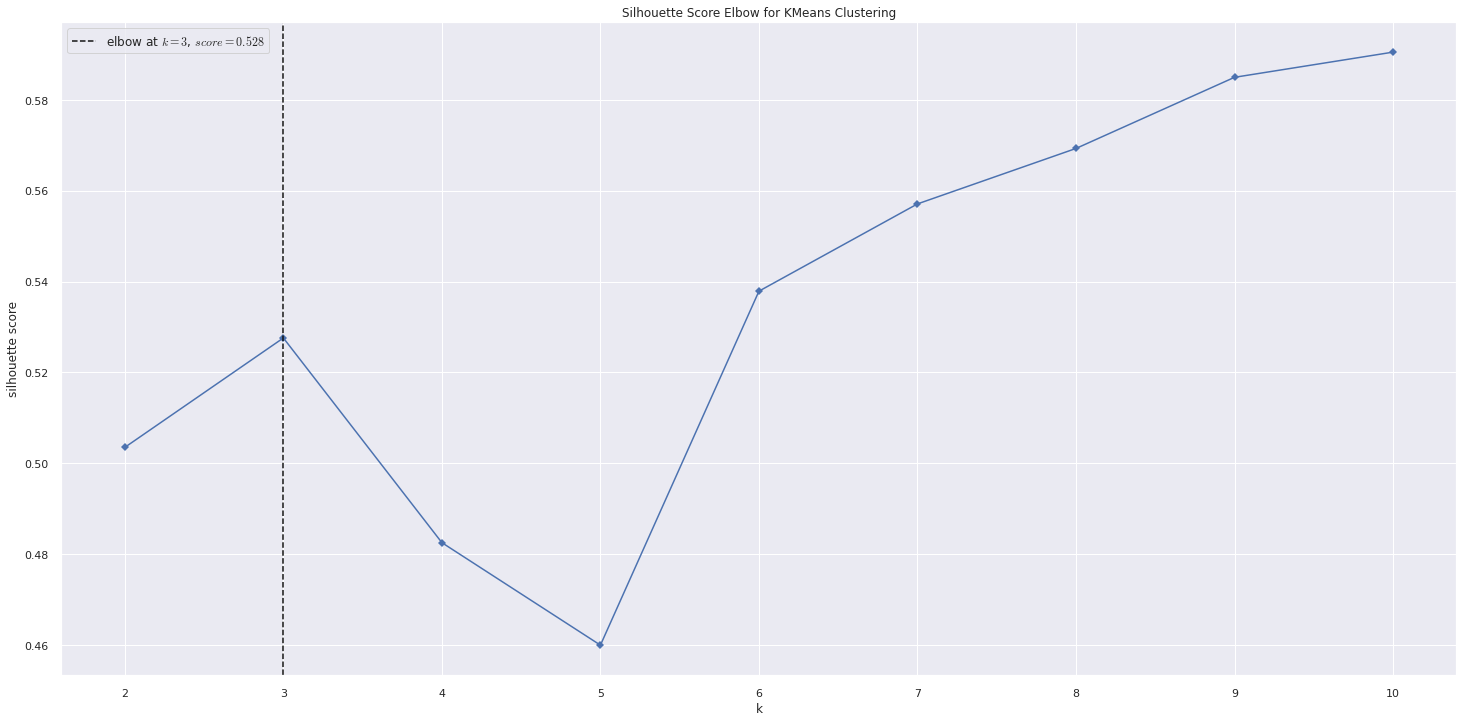

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [230]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(KMeans(),k=clusters,metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show()

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(25,18))

for k in clusters:
    km = KMeans(n_clusters=k,init='random',n_init=10,max_iter=100,random_state=42)
    q, mod = divmod(k,2)
    visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 Model Training

## 8.1 K-Means

In [85]:
# model defintion
k = 9
# Model Definition
kmeans = KMeans(init='random',n_clusters=k,n_init=300,max_iter=300,random_state=42)

# Model Training
kmeans.fit(X)

# Clustering
labels_kmeans = kmeans.predict(X)

sil = silhouette_score(X,labels_kmeans,metric='euclidean')
print(sil)


0.584984


## 8.2 GMM

In [86]:
k = 10
# Model Definition
gmm_model = GaussianMixture(n_components=k,n_init=300,random_state=42)

# Model Training
gmm_model.fit(X)

# Model Predict
labels_gmm = gmm_model.predict(X)

sil = silhouette_score(X,labels_gmm,metric='euclidean')
print(sil)




0.5697483


## 8.3 Hierarquichal Clustering

In [87]:
k = 10

# Model Definition & Training
hc_model = linkage(X,'ward')


# Model Predict
labels_hc = fcluster(hc_model, k, criterion="maxclust")

# Metrics

sil = silhouette_score(X,labels_hc,metric='euclidean')

print(sil)

0.5904487


# 9.0 Cluster Analysis

In [88]:
df9 = X.copy()
df9['cluster'] = labels_hc
#df9['cluster'] = labels_kmeans
#df9['cluster'] = labels_gmm

df9.head()

,embedding_x,embedding_y,cluster
0,-7.599470,6.604761,2
1,-6.919362,6.901824,2
2,-3.044603,1.879497,3
3,-3.206161,11.499099,1
4,-3.208644,11.180527,1


## 9.1 Visualization Inspection

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

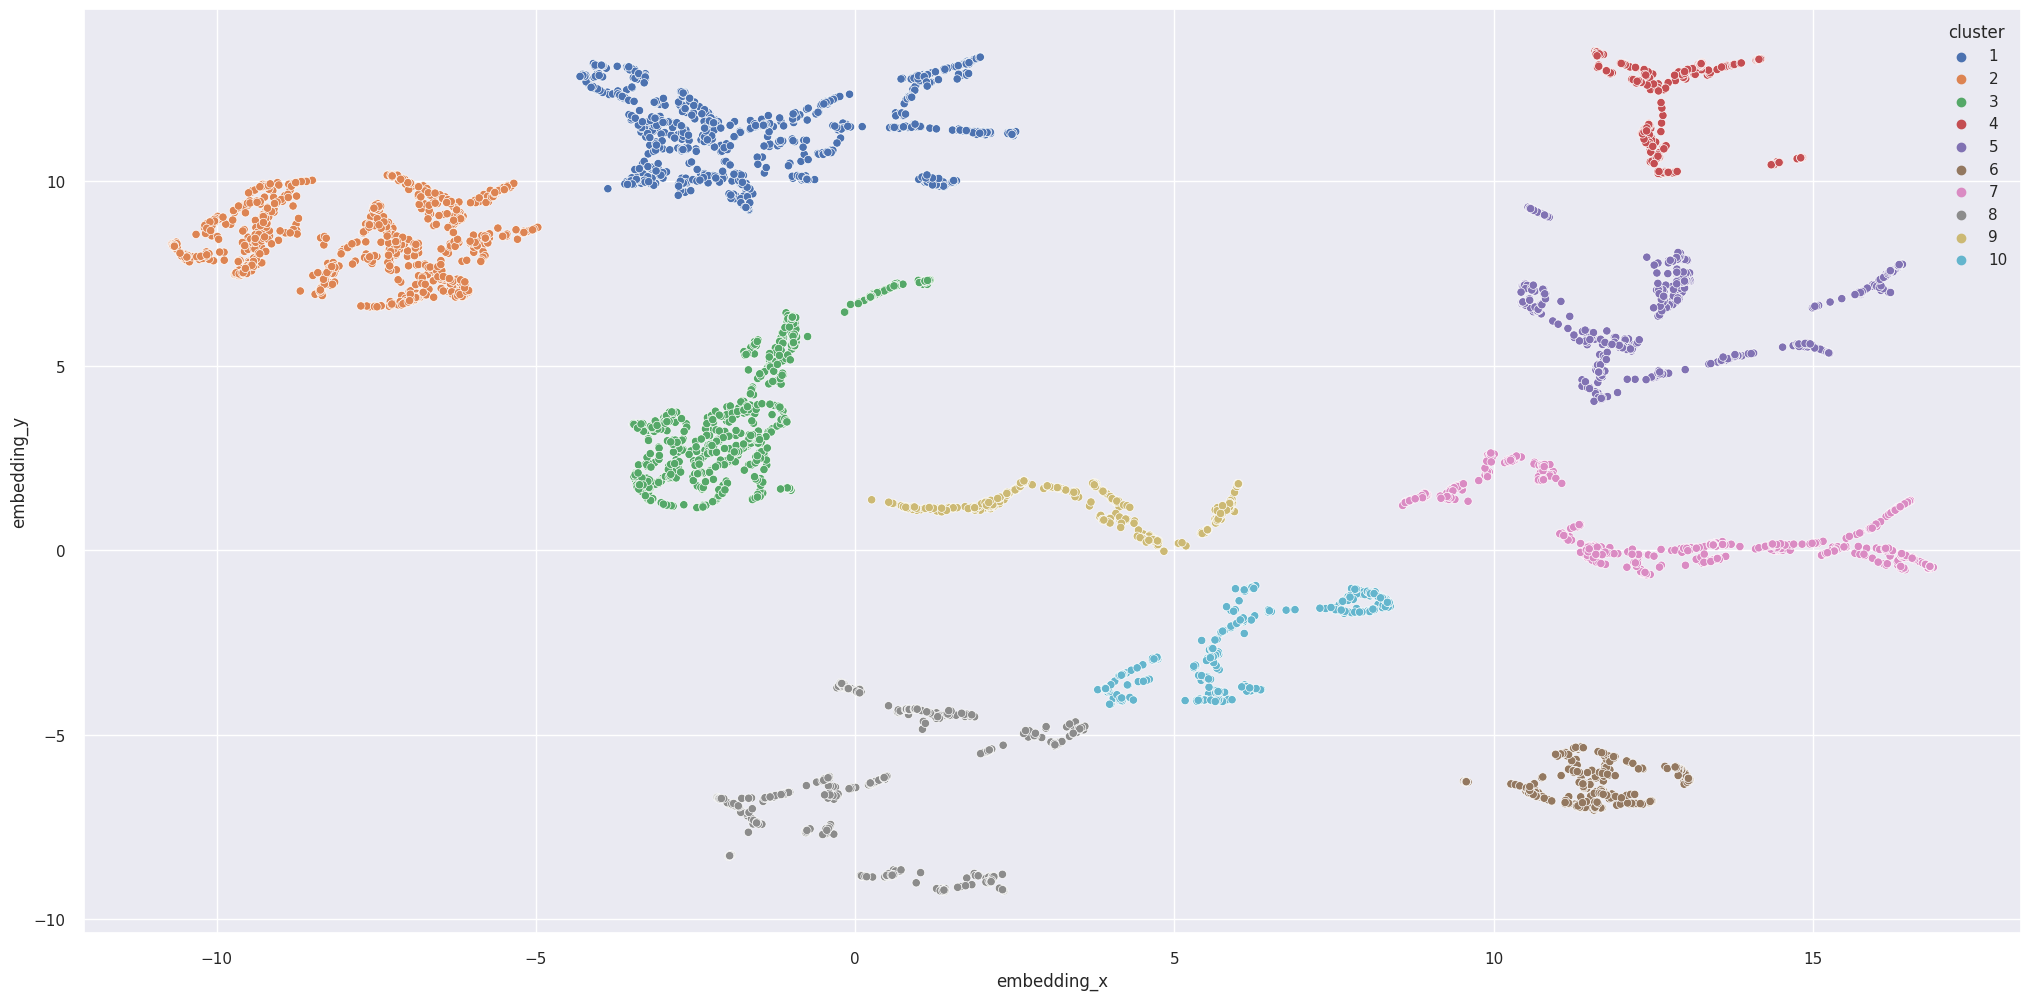

In [89]:
sns.scatterplot(x='embedding_x',y='embedding_y',hue='cluster',data=df9,palette='deep')

## 9.2 Cluster Profile

In [90]:
df92 = df4[['customer_id','gross_revenue','recency_days','qtd_invoices','qtd_items','qtd_items_variety','frequency','qtde_returns','percentage_returned']].copy()
df92['cluster'] = labels_hc
#df92['cluster'] = labels_kmeans
# df92['cluster'] = labels_gmm

In [91]:
# Number of Customers
df_cluster = df92[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['percentage'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross Revenue
df_avg_revenue = df92[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_revenue,how='inner',on='cluster')

# Avg Recency Days
df_avg_recency = df92[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_recency,how='inner',on='cluster')


# Avg qtd_invoices
df_qtd_invoice = df92[['qtd_invoices','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_qtd_invoice,how='inner',on='cluster')

# Avg qtd_items
df_qtd_items = df92[['qtd_items','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_qtd_items,how='inner',on='cluster')


# Avg qtd_items_variety
df_items_variety = df92[['qtd_items_variety','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_items_variety,how='inner',on='cluster')

# Avg frequency
df_avg_frequency = df92[['frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_frequency,how='inner',on='cluster')

# Avg qtde_returns
df_qtde_returns = df92[['qtde_returns','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_qtde_returns,how='inner',on='cluster')

# Avg returned_percentage
# df_percentage_returned = df92[['percentage_returned','cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster,df_percentage_returned,how='inner',on='cluster')

In [92]:
df_cluster.sort_values('gross_revenue',ascending=False)

,cluster,customer_id,percentage,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns
2,3,745,13.118507,5923.995826,5.157047,10.565101,3362.387919,239.135570,0.066298,52.885906
1,2,963,16.957211,2844.796532,56.153686,6.048806,1754.325026,158.605400,0.050185,49.620976
7,8,515,9.068498,2232.303476,181.502913,1.067961,682.027184,214.161165,0.998067,0.471845
9,10,369,6.497623,1048.719051,126.113821,1.100271,554.146341,41.392954,1.034641,1.596206
0,1,990,17.432647,778.561859,90.018182,2.926263,441.333333,33.289899,0.027860,8.630303
8,9,330,5.810882,427.147394,16.500000,1.130303,186.136364,30.009091,0.969006,0.121212
5,6,316,5.564360,401.676899,244.598101,1.003165,116.465190,42.259494,1.003165,0.031646
6,7,574,10.107413,303.000470,112.977352,1.102787,125.886760,11.912892,0.988999,4.191638
4,5,583,10.265892,175.742624,270.039451,1.001715,90.497427,11.284734,0.998666,0.001715
3,4,294,5.176968,50.569218,242.578231,1.000000,12.857143,3.738095,1.000000,0.000000


# 10.0 Post Profile Data Analysis 

In [93]:
df10 = df92.copy()

In [94]:
df10.head()

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns,percentage_returned,cluster
0,17850,5391.21,372.0,34.0,1733.0,297.0,17.000000,40.0,2.308136,2
1,13047,3232.59,56.0,9.0,1390.0,171.0,0.028302,35.0,2.517986,2
2,12583,6705.38,2.0,15.0,5028.0,232.0,0.040323,50.0,0.994431,3
3,13748,948.25,95.0,5.0,439.0,28.0,0.017921,0.0,0.000000,1
4,15100,876.00,333.0,3.0,80.0,3.0,0.073171,22.0,27.500000,1


## 10.1 MindMap Hypothesis 

- 1. Fenômeno
- 2. Entidades ( Customer, Location, Finance, Family)
- 3. Características da Entidade (Customer = Nome, Idade, Salario, ...)


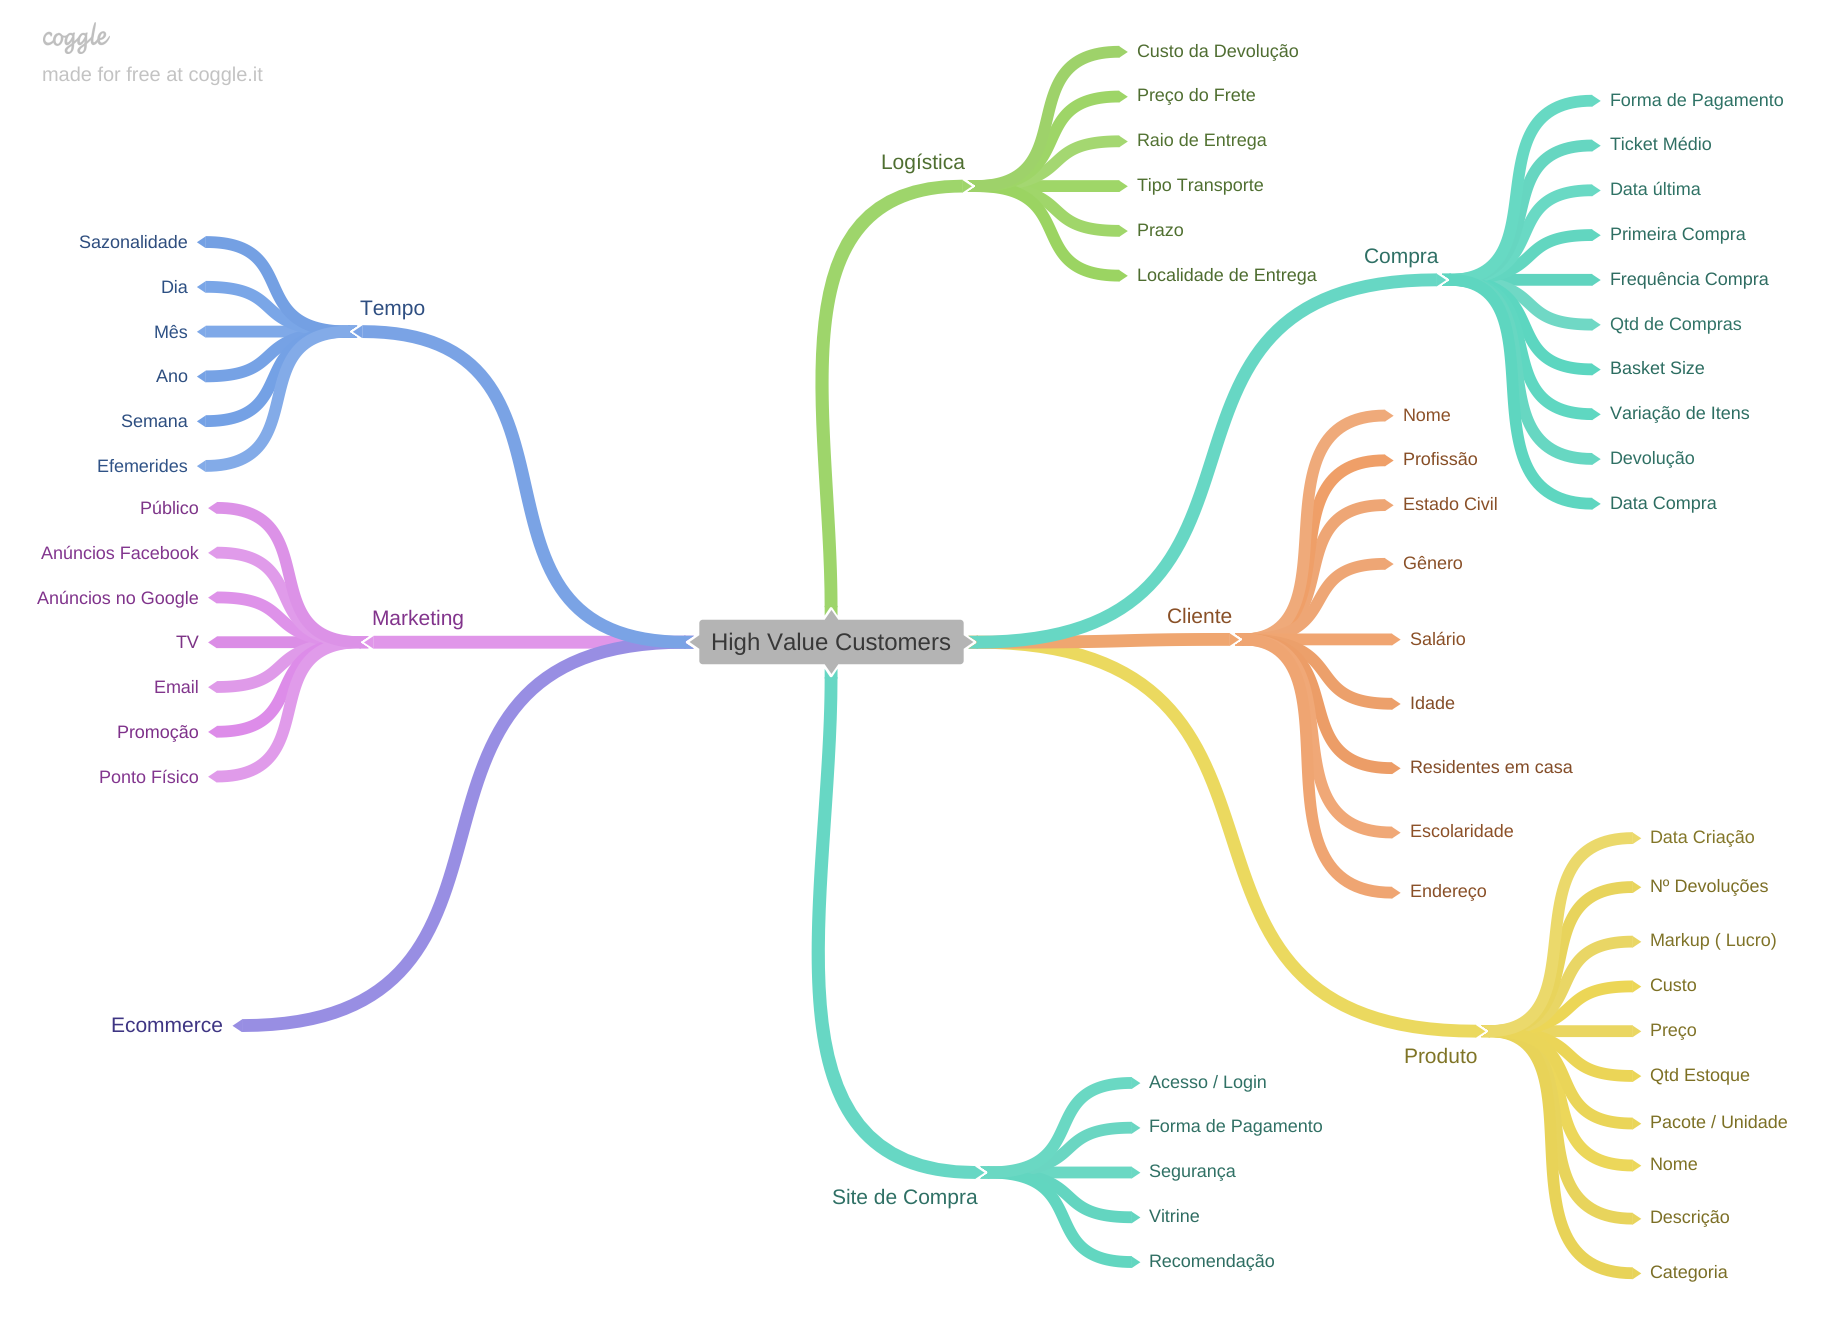

In [95]:
Image('High_Value_Customers.png')

## 10.2 Business Hypothesis

* 1. Afirmação
* 2. Comparação entre Variáveis
* 3. Valor base de Comparação

In [96]:
df_cluster = df_cluster.sort_values('gross_revenue',ascending=False)
df_cluster

,cluster,customer_id,percentage,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns
2,3,745,13.118507,5923.995826,5.157047,10.565101,3362.387919,239.135570,0.066298,52.885906
1,2,963,16.957211,2844.796532,56.153686,6.048806,1754.325026,158.605400,0.050185,49.620976
7,8,515,9.068498,2232.303476,181.502913,1.067961,682.027184,214.161165,0.998067,0.471845
9,10,369,6.497623,1048.719051,126.113821,1.100271,554.146341,41.392954,1.034641,1.596206
0,1,990,17.432647,778.561859,90.018182,2.926263,441.333333,33.289899,0.027860,8.630303
8,9,330,5.810882,427.147394,16.500000,1.130303,186.136364,30.009091,0.969006,0.121212
5,6,316,5.564360,401.676899,244.598101,1.003165,116.465190,42.259494,1.003165,0.031646
6,7,574,10.107413,303.000470,112.977352,1.102787,125.886760,11.912892,0.988999,4.191638
4,5,583,10.265892,175.742624,270.039451,1.001715,90.497427,11.284734,0.998666,0.001715
3,4,294,5.176968,50.569218,242.578231,1.000000,12.857143,3.738095,1.000000,0.000000


- Cluster [3]   -> (13.1%)  ---> INSIDERS
- Cluster [2]   -> (16.9%)  ---> MOST VALUABLE
- Cluster [8]   -> (9.0%)   ---> VALUABLE
- Cluster [10]   -> (6.4%)   ---> GOOD
- Cluster [1]   -> (17.4%)  ---> OK

- Cluster [9]   -> (5.8%)   ---> CHURN 1
- Cluster [6]   -> (5.5%)   ---> CHURN 2
- Cluster [7]  -> (10.6%)  ---> CHURN 3
- Cluster [5]   -> (9.6%)   ---> CHURN 4
- Cluster [4]   -> (5.1%)   ---> CHURN 5


### Purchase Hypothesis

#### H3. Customers in the INSIDERS group have a purchase value above 10% of the company's total revenue.

***TRUE*** - The INSIDERS group is responsible for 44.05% of the company's total revenue.

In [97]:
X = df10[['cluster','gross_revenue']].groupby('cluster').sum().reset_index()
# Calculate the percentage
percentage = X.loc[X['cluster'] == 3, 'gross_revenue'].item() / ( sum(X['gross_revenue'] ) ) #- X.iloc[2]['gross_revenue'] 
percentage = percentage * 100

print('Percentage of revenue coming from Insiders in total: {:.2f}%'.format(percentage))


Percentage of revenue coming from Insiders in total: 44.05%


#### H4. Customers in the INSIDERS group have a purchase volume of unique products above 10% of the all company.
***TRUE*** - The INSIDERS cluster customer has a purchase volume of unique products of 33%.

In [98]:
X = df10[['cluster','qtd_items_variety']].groupby('cluster').sum().reset_index()

percentage = X.loc[X['cluster'] == 3, 'qtd_items_variety'].item() / sum (X['qtd_items_variety'])
percentage = percentage * 100
print('Percentage of purchase volume by Insiders comparing to the total: {:.2f}%'.format(percentage))


Percentage of purchase volume by Insiders comparing to the total: 33.79%


#### H5. Customers in the INSIDERS group have the AVG of returned products lower than the AVG of the rest of the clusters
***FALSE*** - The Insiders group returns 3.0x more products in comparison the all dataset


In [99]:
avg_return_insiders = df10.loc[df10['cluster'] == 3, 'qtde_returns'].mean()
avg_return_all = df10['qtde_returns'].mean()


print('Avg Products Returned INSIDER: {:.0f}'.format(avg_return_insiders))
print('Avg Products Returned by All Clusters: {:.0f}'.format(avg_return_all))
print('The Insiders group returns {:.0f}x more products in comparison the all dataset'.format(avg_return_insiders/avg_return_all))


Avg Products Returned INSIDER: 53
Avg Products Returned by All Clusters: 17
The Insiders group returns 3x more products in comparison the all dataset


### Customer Hypothesis



THIS HYPOTHESIS COULDNT BE USED DUE TO THE LACK OF INFORMATION OF THE CUSTOMERS

H5. 80% of Insiders group clients are married

H6. 10% of Insiders group clients have between 24-40 years.

H7. 30% of Insiders cluster delivery locations are within a 50km radius.

H8. 5% of Insiders cluster customers earn more than $100K annually.

H9. 90% of Insiders cluster customers have completed higher education 


### Products Hypothesis


<!-- #### H10. 30% of all large packaged products are purchased by customers of the Insiders cluster.
#### H13. The AVG Weight of products purchased by the Insiders customers is greater than the rest of the other clusters.
#### H14. The AVG age of the products bought by the Insiders group customers is lower than 15 days. -->

#### H11. The median of the revenue by the customers in the Insiders cluster is 10% greater than the median of the overall revenue.

In [100]:
df_median_gmv_insiders = df10.loc[df10['cluster'] == 3, 'gross_revenue'].median()
df_median_gmv_insiders

2179.93

In [101]:
df_median_gmv_total = df10.loc[:,'gross_revenue'].median()
df_median_gmv_total

615.39

In [102]:
gmv_dif = (df_median_gmv_insiders - df_median_gmv_total ) / df_median_gmv_total
print('GMV DIFF: {:.2f}%'.format(gmv_dif * 100))

GMV DIFF: 254.24%


#### H12.  The percentile of the gmv of products purchased by insider customers

In [103]:
X = df10[df10['cluster'] == 3]

<AxesSubplot:xlabel='gross_revenue'>

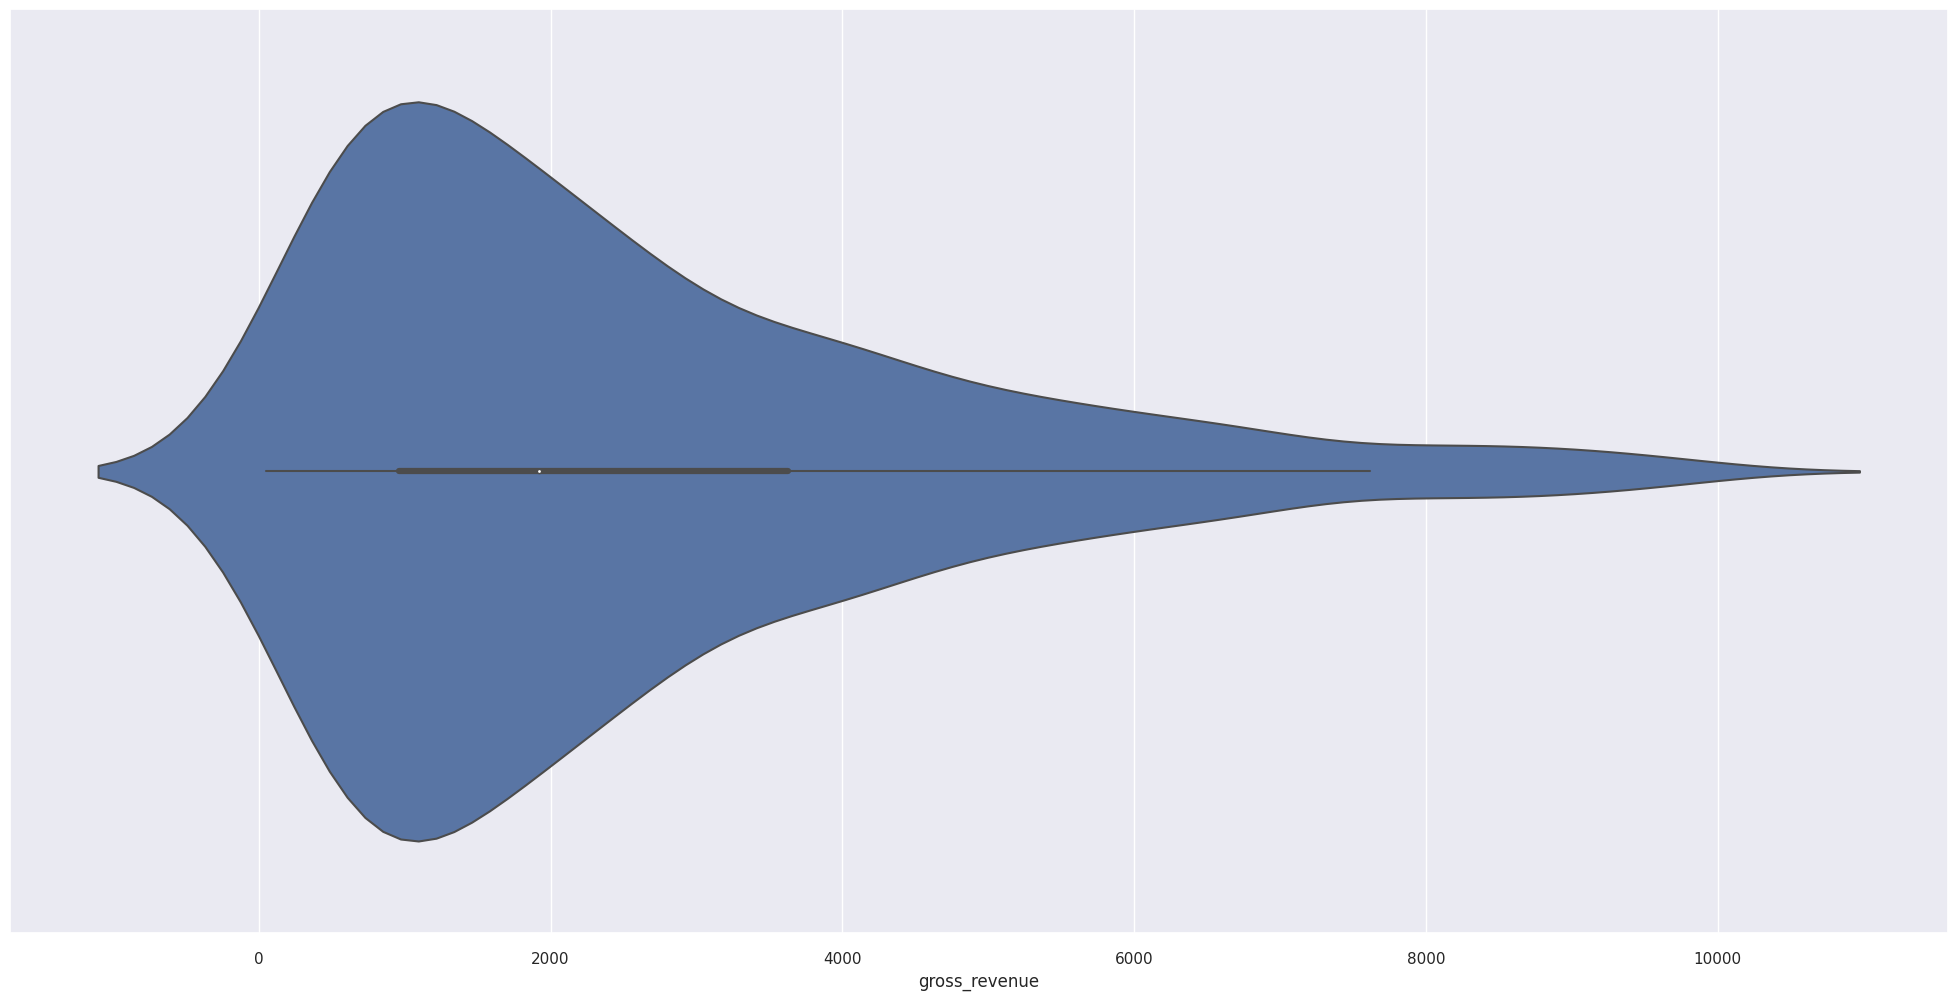

In [104]:
np.percentile(df10.loc[df10['cluster'] == 3, 'gross_revenue'],q = 10)
np.percentile(df10.loc[df10['cluster'] == 3, 'gross_revenue'],q = 90)

df_aux = X[X['gross_revenue'] <= 10000]
sns.violinplot(x=df_aux['gross_revenue']) 

## 10.3 Business Problems and Answers

1. **Who are the people eligible to participate in the Insiders program?**

In [105]:
df_customers = df10.loc[df10['cluster'] == 3,'customer_id']
df_customers.head()

2     12583
6     14688
8     15311
15    17511
16    13705
Name: customer_id, dtype: int64

            
2. **How many customers will be part of the group?**


In [106]:
print('Number of Costumers in the INSIDERS Cluster: {}'.format(df_customers.size))

Number of Costumers in the INSIDERS Cluster: 745


3. **What are the main characteristics of these customers?**

In [107]:
df_cluster[df_cluster['cluster'] == 3]

,cluster,customer_id,percentage,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_items_variety,frequency,qtde_returns
2,3,745,13.118507,5923.995826,5.157047,10.565101,3362.387919,239.13557,0.066298,52.885906


 ***Characteristics of the Insiders Cluster***
 * Number of Costumers : 745 customers - 13.1% of the total. 
 * Average Gross Revenue: U$5.924,000.
 * Average Recency Days: 5 days.
 * Average Quantity of Invoices: 10 invoices (buys).
 * Average Quantity of items purchase: 3362 items.
 * Average Quantity of products variety purchased: 239 different products.
 * Average Frequency of Purchased Products: 0.06
 * Average quantity of returns: 52 returns.


In [108]:
#Info about confidence intervals for Average Revenue
df_loyals = df10.loc[ df10['cluster'] == 3 , 'gross_revenue']

# Boostrap
st.t.interval(alpha = 0.95, #trust level
              df = len(df_loyals-1), #degrees of freedom (df -1)
              loc = np.mean(df_loyals),#mean
              scale = st.sem(df_loyals) ) #std

# We can say that in 95 out of 100 customers, the result will be within the range above.
# The other 5% clients have a good chance of not being part of the cluster in the future, because they are more distant of the mean.



(4574.283648000606, 7273.708003006104)

In [109]:
np.mean(df_loyals)

5923.995825503355

  
4. **What percentage of revenue contribution comes from Insiders?**


In [110]:
df_insiders_gmv = df10.loc[df10['cluster'] == 3, 'gross_revenue'].sum()
df_all_gmv = df10.loc[:,'gross_revenue'].sum()

print('GMV from Insiders {:.2f}%'.format(df_insiders_gmv/df_all_gmv * 100))

GMV from Insiders 44.05%


5. **What is the expected revenue for this group for the coming months?** - TIME SERIES 

R: This question won't be answered right now because we would need a time series organization to predict the future revenue.


6. **What are the conditions for a person to be eligible for Insiders?**

R: The model will define for us. So we would need to create a schedule to run the model monthly and then collect the customer and their cluster assignment each month. We would then compare the previous and current cluster assignment so that we know who moved, stayed, or joined the INSIDERS group.

7. **What are the conditions for a person to be removed from Insiders?**


R: The model will define for us too, just like in the previous question.

8. **What is the guarantee that the Insiders program is better than the rest of the base?**


R: An A/B Test or a Hypothesis test should be runned on next cycles to answer this question properly.

9. **What actions can the marketing team take to increase revenue?**


There are a few actions that the marketing could use:
* Discount
* Purchase Prefence
* Company Visits
* Exclusive Content
* Free Shipping
* More investment in marketing for some specific groups
* Recommend Cross-Sell